# Phase 1 Restart: EDA + Preprocessing + Spatial Grid Foundation

This notebook redoes Phase 1 with the requested scope:
- strong EDA + preprocessing for all four datasets,
- **Step 1:** project latitude/longitude to a metric CRS,
- **Step 2:** create a **sparse spatial base grid** (occupied cells only).

Clustering is intentionally excluded in this notebook and will be handled in the next phase.


## Scope and Method

We treat this as a multi-layer spatial foundation problem:
1. clean each source with explicit logging,
2. inspect quality and distributional behavior,
3. convert all points to a projected system for distance-safe operations,
4. build a sparse grid where each occupied cell is a micro-geographic unit for future feature aggregation and clustering.

This notebook ends at grid creation.


## Explanation Pattern

Each major section follows:
- **Question**
- **Method**
- **What we found**
- **Why this matters for next-phase clustering**


In [4]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install pyproj

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install umap-learn

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install hdbscan

Note: you may need to restart the kernel to use updated packages.


In [8]:
from pathlib import Path
import re
import time
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pyproj import Transformer

import hdbscan
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 180)
sns.set_theme(style='whitegrid', context='notebook')

NOTEBOOK_START = time.time()

DATA_DIR = Path('../data')
OUTPUT_DIR = Path('../outputs/eda')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

TORONTO_BBOX = {
    'lat_min': 43.55,
    'lat_max': 43.90,
    'lon_min': -79.65,
    'lon_max': -79.10,
}

CELL_SIZE_M = 500
MIN_RENTALS_PER_CELL = 5
PROJECTED_CRS = 'EPSG:32617'  # UTM zone 17N (Toronto area)
GEODETIC_CRS = 'EPSG:4326'

## Data Ingestion + Raw Audit

**Question:** What is the baseline quality profile before preprocessing?

**Method:** Load all datasets and compute rows, columns, duplicate rows, missingness, coordinate validity, and Toronto bbox coverage.

**What we found:** The audit table and missingness charts expose where cleaning effort is needed.

**Why this matters for next-phase clustering:** Reliable clustering starts with reliable inputs.


In [10]:
def clean_columns(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out.columns = [str(c).replace('ï»¿', '').strip() for c in out.columns]
    return out


def to_numeric(series: pd.Series) -> pd.Series:
    return pd.to_numeric(series, errors='coerce')


def valid_coord_mask(df: pd.DataFrame, lat_col: str, lon_col: str) -> pd.Series:
    lat = to_numeric(df[lat_col])
    lon = to_numeric(df[lon_col])
    return lat.notna() & lon.notna() & lat.between(-90, 90) & lon.between(-180, 180)


def bbox_mask(df: pd.DataFrame, lat_col: str, lon_col: str) -> pd.Series:
    lat = to_numeric(df[lat_col])
    lon = to_numeric(df[lon_col])
    return lat.between(TORONTO_BBOX['lat_min'], TORONTO_BBOX['lat_max']) & lon.between(TORONTO_BBOX['lon_min'], TORONTO_BBOX['lon_max'])


def parse_currency(value):
    if pd.isna(value):
        return np.nan
    return pd.to_numeric(str(value).replace('$', '').replace(',', '').strip(), errors='coerce')


def parse_bedroom_count(value):
    if pd.isna(value):
        return np.nan

    text = str(value).strip().lower()
    if text in {'studio', 'bachelor'}:
        return 0.0

    nums = re.findall(r'\d+(?:\.\d+)?', text)
    if not nums:
        return np.nan
    return float(nums[0])


def normalize_rest_price(value):
    mapping = {
        'Under $10': 10.0,
        '$11-30': 20.5,
        '$31-60': 45.5,
        'Above $61': 70.0,
        'US$11-30': 20.5,
    }
    if pd.isna(value):
        return np.nan
    text = str(value).strip()
    if text in mapping:
        return mapping[text]

    nums = [int(n) for n in re.findall(r'\d+', text)]
    if len(nums) >= 2:
        return (nums[0] + nums[1]) / 2.0
    if len(nums) == 1:
        return float(nums[0])
    return np.nan


def winsorize_series(series: pd.Series, q_low=0.01, q_high=0.99):
    low, high = series.quantile([q_low, q_high])
    return series.clip(lower=low, upper=high), float(low), float(high)


crime_raw = clean_columns(pd.read_csv(DATA_DIR / 'MCI_2014_to_2019.csv'))
rent_2018_raw = clean_columns(pd.read_csv(DATA_DIR / 'Toronto_apartment_rentals_2018.csv'))
rest_raw = clean_columns(pd.read_csv(DATA_DIR / 'trt_rest.csv'))
subway_raw = clean_columns(pd.read_csv(DATA_DIR / 'toronto_subway_stations.csv'))

rent_2018_raw = rent_2018_raw.copy()
rent_2018_raw['rental_source'] = 'toronto_apartment_rentals_2018'

rent_core_cols = ['Bedroom', 'Bathroom', 'Den', 'Address', 'Lat', 'Long', 'Price', 'rental_source']
rent_base = rent_2018_raw.copy()
for col in rent_core_cols:
    if col not in rent_base.columns:
        rent_base[col] = pd.NA
rent_base = rent_base[rent_core_cols]

rentfaster_path = DATA_DIR / 'rentfaster.csv'
if rentfaster_path.exists():
    rentfaster_raw = clean_columns(pd.read_csv(rentfaster_path))
    rentfaster_norm = rentfaster_raw.copy()
    rentfaster_norm['Bedroom'] = rentfaster_norm['beds'].apply(parse_bedroom_count)
    rentfaster_norm['Bathroom'] = to_numeric(rentfaster_norm['baths'])
    rentfaster_norm['Den'] = 0

    street = rentfaster_norm['address'].astype('string').fillna('').str.strip()
    city = rentfaster_norm['city'].astype('string').fillna('').str.strip()
    province = rentfaster_norm['province'].astype('string').fillna('').str.strip()
    rentfaster_norm['Address'] = (
        street
        + np.where(city.ne(''), ', ' + city, '')
        + np.where(province.ne(''), ', ' + province, '')
    ).str.strip(', ')

    rentfaster_norm['Lat'] = to_numeric(rentfaster_norm['latitude'])
    rentfaster_norm['Long'] = to_numeric(rentfaster_norm['longitude'])
    rentfaster_norm['Price'] = rentfaster_norm['price']
    rentfaster_norm['rental_source'] = 'rentfaster'

    rentfaster_for_merge = rentfaster_norm[rent_core_cols]
    rent_raw = pd.concat([rent_base, rentfaster_for_merge], ignore_index=True)
else:
    rent_raw = rent_base.copy()

raw_datasets = {
    'crime': crime_raw,
    'rentals': rent_raw,
    'restaurants': rest_raw,
    'subway': subway_raw,
}

coord_cols = {
    'crime': ('Lat', 'Long'),
    'rentals': ('Lat', 'Long'),
    'restaurants': ('Restaurant Latitude', 'Restaurant Longitude'),
    'subway': ('latitude', 'longitude'),
}

audit_rows = []
for name, df in raw_datasets.items():
    lat_col, lon_col = coord_cols[name]
    valid = valid_coord_mask(df, lat_col, lon_col)
    bbox = bbox_mask(df, lat_col, lon_col)

    audit_rows.append({
        'dataset': name,
        'rows': int(df.shape[0]),
        'columns': int(df.shape[1]),
        'duplicate_rows': int(df.duplicated().sum()),
        'missingness_pct': round(float(df.isna().sum().sum() / (df.shape[0] * df.shape[1]) * 100), 4),
        'coord_valid_pct': round(float(valid.mean() * 100), 4),
        'toronto_bbox_coverage_pct': round(float(bbox.mean() * 100), 4),
    })

audit_df = pd.DataFrame(audit_rows).sort_values('dataset').reset_index(drop=True)
audit_df.to_csv(OUTPUT_DIR / 'data_quality_audit.csv', index=False)
audit_df


,dataset,rows,columns,duplicate_rows,missingness_pct,coord_valid_pct,toronto_bbox_coverage_pct
0,crime,206435,29,0,0.0049,100.0000,100.0000
1,rentals,1124,8,308,0.0000,100.0000,88.2562
2,restaurants,15821,9,6,7.0048,99.6966,99.3742
3,subway,69,3,0,0.0000,100.0000,100.0000


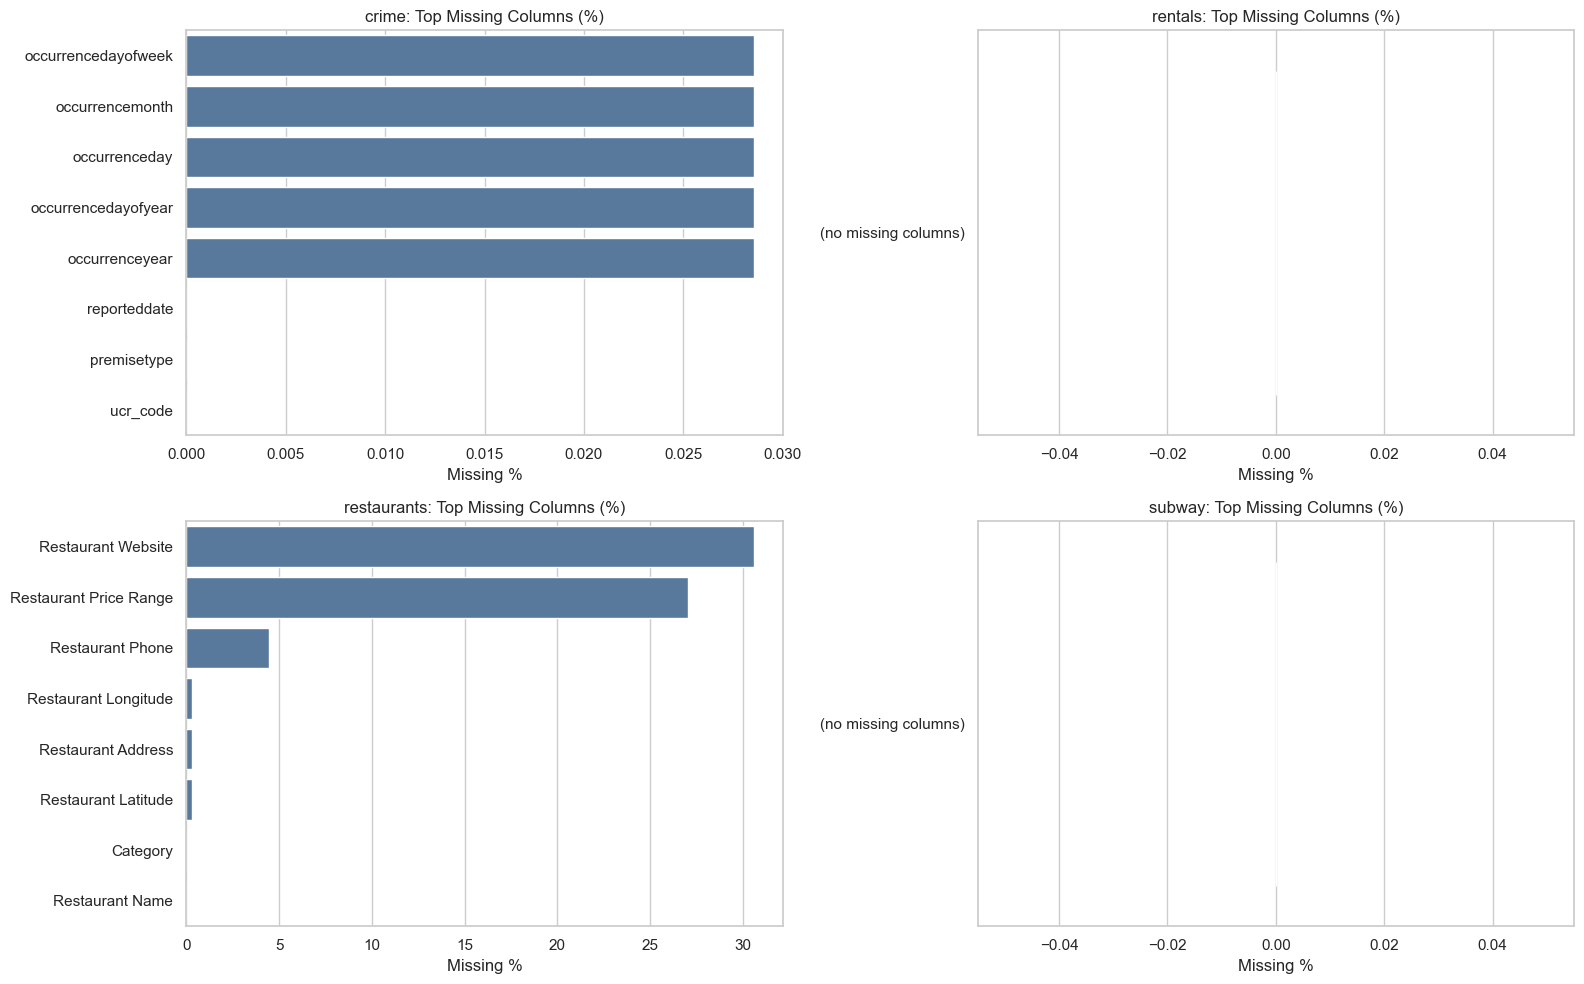

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

for ax, (name, df) in zip(axes, raw_datasets.items()):
    miss = (df.isna().mean() * 100).sort_values(ascending=False).head(8)
    if miss.sum() == 0:
        miss = pd.Series({'(no missing columns)': 0.0})
    sns.barplot(x=miss.values, y=miss.index, ax=ax, color='#4C78A8')
    ax.set_title(f'{name}: Top Missing Columns (%)')
    ax.set_xlabel('Missing %')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

## Preprocessing Engine

**Question:** How do we apply deterministic preprocessing with traceability?

**Method:** Use reusable filter/dedup helpers with step-level drop logging.

**What we found:** Each transformation is accounted for in a drop log table.

**Why this matters for next-phase clustering:** Reproducibility and auditability are critical for team confidence and model governance.


In [13]:
drop_log = []


def log_step(dataset: str, step: str, before: int, after: int, detail: str = ''):
    dropped = int(before - after)
    drop_log.append({
        'dataset': dataset,
        'step': step,
        'rows_before': int(before),
        'rows_after': int(after),
        'dropped_rows': dropped,
        'drop_pct': 0.0 if before == 0 else round(dropped / before * 100, 4),
        'detail': detail,
    })


def apply_filter(df: pd.DataFrame, mask: pd.Series, dataset: str, step: str, detail: str = '') -> pd.DataFrame:
    before = len(df)
    out = df.loc[mask].copy()
    log_step(dataset, step, before, len(out), detail)
    return out


def apply_dedup(df: pd.DataFrame, subset, dataset: str, step: str) -> pd.DataFrame:
    before = len(df)
    out = df.drop_duplicates(subset=subset).copy()
    log_step(dataset, step, before, len(out), f'subset={subset}')
    return out

## Preprocess Crime, Rentals, Restaurants, Subway

**Question:** What cleaned point-level data should feed spatial grid construction?

**Method:** Apply dataset-specific cleaning rules for temporal validity, duplicates, coordinates, plausibility limits, and pricing normalization.

**What we found:** Final cleaned datasets are compact, consistent, and coordinate-safe.

**Why this matters for next-phase clustering:** Better point quality means better spatial feature quality downstream.


In [15]:
# ----- Crime -----
crime = crime_raw.copy()
for col in crime.columns:
    if pd.api.types.is_object_dtype(crime[col]) or pd.api.types.is_string_dtype(crime[col]):
        crime[col] = crime[col].astype('string').str.strip()

crime['occurrenceyear'] = to_numeric(crime['occurrenceyear'])
crime['Lat'] = to_numeric(crime['Lat'])
crime['Long'] = to_numeric(crime['Long'])
crime['MCI'] = crime['MCI'].astype('string').str.strip()
crime['event_unique_id'] = crime['event_unique_id'].astype('string').str.strip()
crime['is_violent'] = crime['MCI'].str.lower().isin({'assault', 'robbery', 'homicide'}).astype(int)

crime = apply_filter(crime, crime['occurrenceyear'].between(2014, 2019, inclusive='both'), 'crime', 'keep_occurrenceyear_2014_2019')
crime = apply_filter(crime, crime[['Lat', 'Long', 'MCI']].notna().all(axis=1), 'crime', 'drop_missing_core_fields')
crime = apply_filter(crime, bbox_mask(crime, 'Lat', 'Long'), 'crime', 'toronto_bbox_filter')
crime = apply_dedup(crime, ['event_unique_id'], 'crime', 'dedup_event_unique_id')

# ----- Rentals -----
rent = rent_raw.copy()
for col in rent.columns:
    if pd.api.types.is_object_dtype(rent[col]) or pd.api.types.is_string_dtype(rent[col]):
        rent[col] = rent[col].astype('string').str.strip()

rent['Lat'] = to_numeric(rent['Lat'])
rent['Long'] = to_numeric(rent['Long'])
rent['Bedroom'] = to_numeric(rent['Bedroom'])
rent['Bathroom'] = to_numeric(rent['Bathroom'])
rent['Den'] = to_numeric(rent['Den'])
rent['Price_num'] = rent['Price'].apply(parse_currency)

rent = apply_dedup(rent, ['Address', 'Bedroom', 'Bathroom', 'Den', 'Lat', 'Long', 'Price'], 'rentals', 'dedup_listing_signature')
rent = apply_filter(rent, rent['Address'].astype('string').str.contains('Toronto', case=False, na=False), 'rentals', 'keep_address_contains_toronto')
rent = apply_filter(rent, rent[['Lat', 'Long', 'Bedroom', 'Bathroom', 'Price_num']].notna().all(axis=1), 'rentals', 'drop_missing_core_fields')
rent = apply_filter(rent, bbox_mask(rent, 'Lat', 'Long'), 'rentals', 'toronto_bbox_filter')
rent = apply_filter(rent, rent['Bedroom'].between(0, 6, inclusive='both'), 'rentals', 'bedroom_plausibility_0_6')
rent = apply_filter(rent, rent['Bathroom'].between(0, 5, inclusive='both'), 'rentals', 'bathroom_plausibility_0_5')
rent = apply_filter(rent, rent['Price_num'].between(400, 10000, inclusive='both'), 'rentals', 'price_plausibility_400_10000')

rent['Price_clean'], q01, q99 = winsorize_series(rent['Price_num'], 0.01, 0.99)
rent['price_was_winsorized'] = ((rent['Price_num'] < q01) | (rent['Price_num'] > q99)).astype(int)
rent['price_per_bedroom'] = rent['Price_clean'] / rent['Bedroom'].clip(lower=1)
log_step('rentals', 'winsorize_price_q01_q99', len(rent), len(rent), f'q01={q01:.2f};q99={q99:.2f};winsorized_rows={int(rent.price_was_winsorized.sum())}')

# ----- Restaurants -----
rest = rest_raw.copy()
for col in rest.columns:
    if pd.api.types.is_object_dtype(rest[col]) or pd.api.types.is_string_dtype(rest[col]):
        rest[col] = rest[col].astype('string').str.strip()

rest['Restaurant Latitude'] = to_numeric(rest['Restaurant Latitude'])
rest['Restaurant Longitude'] = to_numeric(rest['Restaurant Longitude'])
rest['Category'] = rest['Category'].astype('string').str.strip().replace({'<NA>': pd.NA}).fillna('Unknown')
rest['Restaurant Name'] = rest['Restaurant Name'].astype('string').str.strip()
rest['Restaurant Address'] = rest['Restaurant Address'].astype('string').str.strip()
rest['restaurant_price_mid'] = rest['Restaurant Price Range'].apply(normalize_rest_price)
rest['restaurant_price_missing_original'] = rest['restaurant_price_mid'].isna().astype(int)

rest = apply_filter(rest, rest[['Restaurant Latitude', 'Restaurant Longitude']].notna().all(axis=1), 'restaurants', 'drop_missing_coords')
rest = apply_filter(rest, bbox_mask(rest, 'Restaurant Latitude', 'Restaurant Longitude'), 'restaurants', 'toronto_bbox_filter')
rest = apply_filter(rest, rest['Restaurant Address'].astype('string').str.contains('Toronto', case=False, na=False), 'restaurants', 'keep_address_contains_toronto')

cat_median = rest.groupby('Category')['restaurant_price_mid'].transform('median')
rest['restaurant_price_mid'] = rest['restaurant_price_mid'].fillna(cat_median)
rest_global_med = float(rest['restaurant_price_mid'].median())
rest['restaurant_price_mid'] = rest['restaurant_price_mid'].fillna(rest_global_med)
log_step('restaurants', 'impute_restaurant_price_category_then_global', len(rest), len(rest), f'global_median={rest_global_med:.2f}')

# venue-level for point density/grid occupancy
rest_venue = apply_dedup(rest, ['Restaurant Name', 'Restaurant Address', 'Restaurant Latitude', 'Restaurant Longitude'], 'restaurants', 'dedup_restaurant_venue_signature')

# ----- Subway -----
subway = subway_raw.copy()
for col in subway.columns:
    if pd.api.types.is_object_dtype(subway[col]) or pd.api.types.is_string_dtype(subway[col]):
        subway[col] = subway[col].astype('string').str.strip()

subway['latitude'] = to_numeric(subway['latitude'])
subway['longitude'] = to_numeric(subway['longitude'])
subway = apply_filter(subway, subway[['latitude', 'longitude']].notna().all(axis=1), 'subway', 'drop_missing_coords')
subway = apply_dedup(subway, ['name', 'latitude', 'longitude'], 'subway', 'dedup_station_signature')
subway = apply_filter(subway, bbox_mask(subway, 'latitude', 'longitude'), 'subway', 'toronto_bbox_filter')

cleaned_counts_df = pd.DataFrame([
    {'dataset': 'crime', 'rows_clean': len(crime)},
    {'dataset': 'rentals', 'rows_clean': len(rent)},
    {'dataset': 'restaurants_venue', 'rows_clean': len(rest_venue)},
    {'dataset': 'subway', 'rows_clean': len(subway)},
])

a = rent_raw['rental_source'].astype('string').fillna('unknown').value_counts().rename('rows_raw')
b = rent['rental_source'].astype('string').fillna('unknown').value_counts().rename('rows_clean')
rental_source_summary = (
    pd.concat([a, b], axis=1)
    .fillna(0)
    .astype(int)
    .reset_index()
    .rename(columns={'index': 'rental_source'})
    .sort_values('rows_clean', ascending=False)
    .reset_index(drop=True)
)

display(cleaned_counts_df)
rental_source_summary

,dataset,rows_clean
0,crime,178892
1,rentals,595
2,restaurants_venue,6101
3,subway,69


,rental_source,rows_raw,rows_clean
0,toronto_apartment_rentals_2018,1124,595


## Preprocessing Log and Recap

**Question:** How many rows were removed by each preprocessing rule?

**Method:** Persist step-level drop log and summarize raw vs cleaned counts.

**What we found:** Most reductions come from duplicate and location validity controls.

**Why this matters for next-phase clustering:** Quantified preprocessing effects avoid hidden data shifts.


In [17]:
drop_log_df = pd.DataFrame(drop_log)
drop_log_df.to_csv(OUTPUT_DIR / 'preprocessing_drop_log.csv', index=False)

recap = pd.DataFrame([
    {'dataset': 'crime', 'rows_raw': len(crime_raw), 'rows_clean': len(crime)},
    {'dataset': 'rentals', 'rows_raw': len(rent_raw), 'rows_clean': len(rent)},
    {'dataset': 'restaurants', 'rows_raw': len(rest_raw), 'rows_clean': len(rest_venue)},
    {'dataset': 'subway', 'rows_raw': len(subway_raw), 'rows_clean': len(subway)},
])

recap

,dataset,rows_raw,rows_clean
0,crime,206435,178892
1,rentals,1124,595
2,restaurants,15821,6101
3,subway,69,69


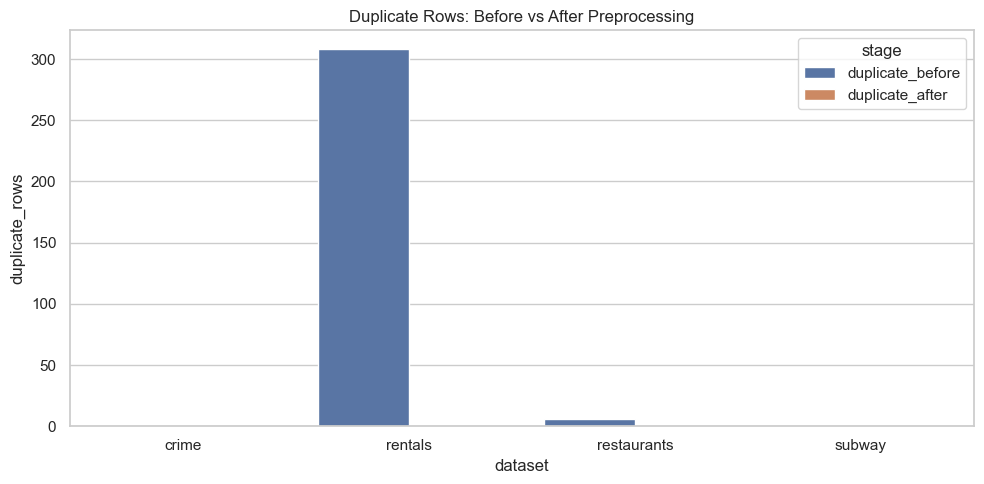

,dataset,duplicate_before,duplicate_after
0,crime,0,0
1,rentals,308,0
2,restaurants,6,0
3,subway,0,0


In [18]:
dup_summary = pd.DataFrame([
    {
        'dataset': name,
        'duplicate_before': int(raw_datasets[name].duplicated().sum()),
        'duplicate_after': int(df.duplicated().sum()),
    }
    for name, df in [('crime', crime), ('rentals', rent), ('restaurants', rest_venue), ('subway', subway)]
])

dup_long = dup_summary.melt(id_vars='dataset', var_name='stage', value_name='duplicate_rows')

plt.figure(figsize=(10, 5))
sns.barplot(data=dup_long, x='dataset', y='duplicate_rows', hue='stage')
plt.title('Duplicate Rows: Before vs After Preprocessing')
plt.tight_layout()
plt.show()

dup_summary

## EDA Highlights After Cleaning

**Question:** What are the cleaned distributions that will influence future clustering?

**Method:** Inspect temporal crime structure, rental price behavior, and amenity composition.

**What we found:** Core distributional patterns are visible and cleaner than raw data.

**Why this matters for next-phase clustering:** These are the feature-generating signals for later unsupervised learning.


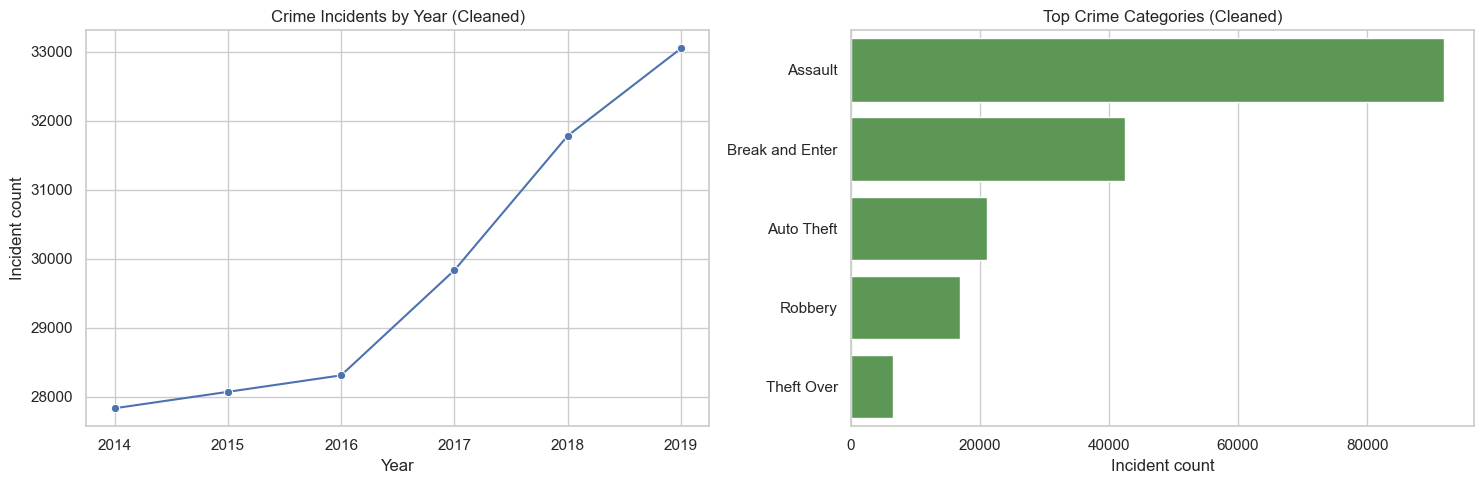

In [20]:
crime_year = (
    crime.groupby('occurrenceyear', as_index=False)
    .size()
    .rename(columns={'size': 'incident_count'})
    .sort_values('occurrenceyear')
)

top_mci = crime['MCI'].value_counts().head(12).rename_axis('MCI').reset_index(name='count')

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(data=crime_year, x='occurrenceyear', y='incident_count', marker='o', ax=axes[0])
axes[0].set_title('Crime Incidents by Year (Cleaned)')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Incident count')

sns.barplot(data=top_mci, y='MCI', x='count', ax=axes[1], color='#54A24B')
axes[1].set_title('Top Crime Categories (Cleaned)')
axes[1].set_xlabel('Incident count')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

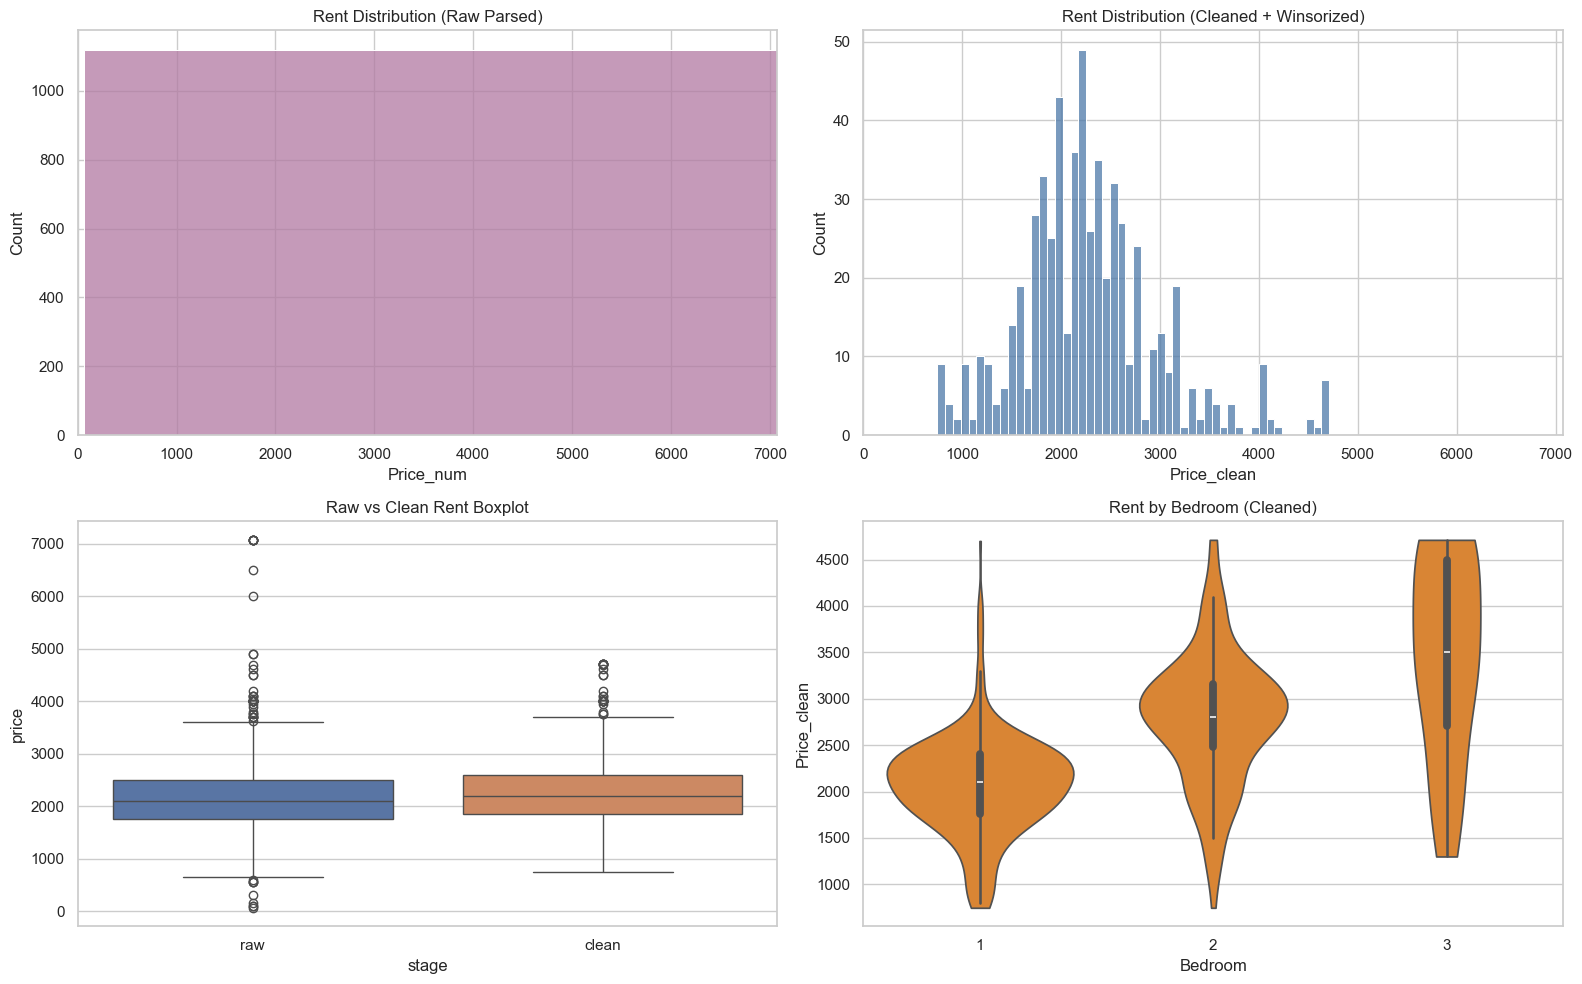

In [21]:
rent_before = rent_raw.copy()
rent_before['Price_num'] = rent_before['Price'].apply(parse_currency)
rent_before = rent_before[rent_before['Price_num'].notna()]

display_cap = np.nanpercentile(rent_before['Price_num'], 99.5)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

sns.histplot(rent_before['Price_num'], bins=50, ax=axes[0, 0], color='#B279A2')
axes[0, 0].set_title('Rent Distribution (Raw Parsed)')
axes[0, 0].set_xlim(0, display_cap)

sns.histplot(rent['Price_clean'], bins=50, ax=axes[0, 1], color='#4C78A8')
axes[0, 1].set_title('Rent Distribution (Cleaned + Winsorized)')
axes[0, 1].set_xlim(0, display_cap)

box_df = pd.DataFrame({
    'raw': rent_before['Price_num'].clip(upper=display_cap),
    'clean': rent['Price_clean'].clip(upper=display_cap),
}).melt(var_name='stage', value_name='price')

sns.boxplot(data=box_df, x='stage', y='price', hue='stage', legend=False, ax=axes[1, 0])
axes[1, 0].set_title('Raw vs Clean Rent Boxplot')

sns.violinplot(data=rent[rent['Bedroom'].between(0, 6, inclusive='both')], x='Bedroom', y='Price_clean', ax=axes[1, 1], color='#F58518', cut=0)
axes[1, 1].set_title('Rent by Bedroom (Cleaned)')

plt.tight_layout()
plt.show()

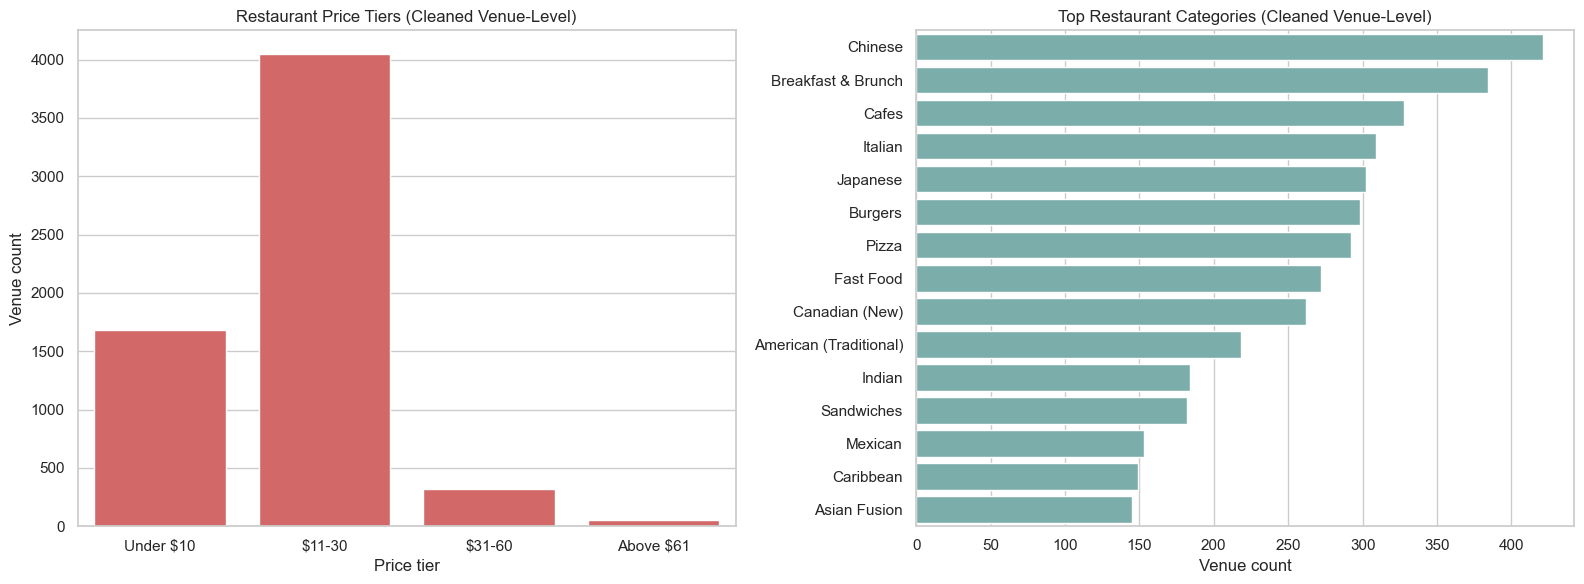

In [22]:
price_bins = pd.cut(
    rest_venue['restaurant_price_mid'],
    bins=[0, 10.5, 30.5, 60.5, np.inf],
    labels=['Under $10', '$11-30', '$31-60', 'Above $61'],
    include_lowest=True,
)

price_counts = price_bins.value_counts().rename_axis('price_range').reset_index(name='count')
top_categories = rest_venue['Category'].value_counts().head(15).rename_axis('Category').reset_index(name='count')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(data=price_counts, x='price_range', y='count', ax=axes[0], color='#E45756')
axes[0].set_title('Restaurant Price Tiers (Cleaned Venue-Level)')
axes[0].set_xlabel('Price tier')
axes[0].set_ylabel('Venue count')

sns.barplot(data=top_categories, y='Category', x='count', ax=axes[1], color='#72B7B2')
axes[1].set_title('Top Restaurant Categories (Cleaned Venue-Level)')
axes[1].set_xlabel('Venue count')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

## Step 1: Standardize Coordinate System (Projected CRS)

**Question:** How do we convert all datasets into a distance-safe coordinate system?

**Method:** Transform from WGS84 (`EPSG:4326`) to UTM Zone 17N (`EPSG:32617`) using `pyproj`.

**What we found:** All cleaned points receive metric `x_m`/`y_m` coordinates.

**Why this matters for next-phase clustering:** Grid construction and distance-based analytics require projected coordinates in meters.


In [24]:
fwd_transformer = Transformer.from_crs(GEODETIC_CRS, PROJECTED_CRS, always_xy=True)
inv_transformer = Transformer.from_crs(PROJECTED_CRS, GEODETIC_CRS, always_xy=True)


def add_projected_xy(df: pd.DataFrame, lat_col: str, lon_col: str) -> pd.DataFrame:
    out = df.copy()
    lon = out[lon_col].to_numpy(dtype=float)
    lat = out[lat_col].to_numpy(dtype=float)
    x_m, y_m = fwd_transformer.transform(lon, lat)
    out['x_m'] = x_m
    out['y_m'] = y_m
    return out


crime_proj = add_projected_xy(crime, 'Lat', 'Long')
rent_proj = add_projected_xy(rent, 'Lat', 'Long')
rest_proj = add_projected_xy(rest_venue, 'Restaurant Latitude', 'Restaurant Longitude')
subway_proj = add_projected_xy(subway, 'latitude', 'longitude')

projected_summary = pd.DataFrame([
    {
        'dataset': 'crime',
        'rows': len(crime_proj),
        'x_min': float(crime_proj['x_m'].min()),
        'x_max': float(crime_proj['x_m'].max()),
        'y_min': float(crime_proj['y_m'].min()),
        'y_max': float(crime_proj['y_m'].max()),
    },
    {
        'dataset': 'rentals',
        'rows': len(rent_proj),
        'x_min': float(rent_proj['x_m'].min()),
        'x_max': float(rent_proj['x_m'].max()),
        'y_min': float(rent_proj['y_m'].min()),
        'y_max': float(rent_proj['y_m'].max()),
    },
    {
        'dataset': 'restaurants',
        'rows': len(rest_proj),
        'x_min': float(rest_proj['x_m'].min()),
        'x_max': float(rest_proj['x_m'].max()),
        'y_min': float(rest_proj['y_m'].min()),
        'y_max': float(rest_proj['y_m'].max()),
    },
    {
        'dataset': 'subway',
        'rows': len(subway_proj),
        'x_min': float(subway_proj['x_m'].min()),
        'x_max': float(subway_proj['x_m'].max()),
        'y_min': float(subway_proj['y_m'].min()),
        'y_max': float(subway_proj['y_m'].max()),
    },
])

projected_summary

,dataset,rows,x_min,x_max,y_min,y_max
0,crime,178892,609553.297485,651013.761687,4.827050e+06,4.856893e+06
1,rentals,595,615841.359269,639251.838862,4.827620e+06,4.848684e+06
2,restaurants,6101,612524.964770,645595.345413,4.827639e+06,4.854102e+06
3,subway,69,618127.250702,639827.107006,4.832667e+06,4.848802e+06


## Step 2: Create Adaptive Sparse Grid (Equal-Rental-Count Circles)

**Question:** How do we build spatial units where low-density areas become larger and high-density areas become smaller without spatial overlap artifacts?

**Method:**
- Start from a very fine projected mesh (`100m x 100m`) and use occupied mesh cells as seed locations.
- Grow each seed cell outward ring-by-ring, collecting nearby rentals until exactly **3 rentals** are available.
- Stop growth immediately at 3 rentals and set the circle radius to the 3rd rental distance from the seed center.
- Enforce one-to-one rental membership (each rental can belong to only one adaptive cell).
- For crime/restaurants/subway counts, assign each point to its **nearest adaptive cell center** (no double counting across overlapping circles).

**What we found:** Adaptive cells now reflect local density while avoiding inflated counts caused by overlapping circle coverage.

**Why this matters for next-phase clustering:** Features become spatially stable and interpretable because each point contributes to exactly one adaptive unit.


In [26]:
K_RENTALS_PER_CELL = 3
MESH_CELL_SIZE_M = 100.0
MAX_GROWTH_RADIUS_M = 3000.0
MAX_RING_STEPS = int(np.ceil(MAX_GROWTH_RADIUS_M / MESH_CELL_SIZE_M))

from collections import defaultdict

rent_core = rent_proj[['x_m', 'y_m', 'Lat', 'Long', 'Price_clean', 'price_per_bedroom']].reset_index(drop=True)
rent_xy = rent_core[['x_m', 'y_m']].to_numpy(dtype=float)

# Build a fine projected mesh and attach each rental to a mesh cell.
mesh_origin_x = float(np.floor(rent_xy[:, 0].min() / MESH_CELL_SIZE_M) * MESH_CELL_SIZE_M)
mesh_origin_y = float(np.floor(rent_xy[:, 1].min() / MESH_CELL_SIZE_M) * MESH_CELL_SIZE_M)
grid_x = np.floor((rent_xy[:, 0] - mesh_origin_x) / MESH_CELL_SIZE_M).astype(int)
grid_y = np.floor((rent_xy[:, 1] - mesh_origin_y) / MESH_CELL_SIZE_M).astype(int)

rent_core['grid_x'] = grid_x
rent_core['grid_y'] = grid_y

cell_to_indices = defaultdict(set)
for idx, (gx, gy) in enumerate(zip(grid_x, grid_y)):
    cell_to_indices[(int(gx), int(gy))].add(int(idx))

unassigned = set(range(len(rent_core)))
blocked_seed_cells = set()
adaptive_rows = []
cell_id = 0


def ring_cells(seed_cell, ring):
    sx, sy = seed_cell
    if ring == 0:
        return [(sx, sy)]

    out = []
    for dx in range(-ring, ring + 1):
        out.append((sx + dx, sy - ring))
        out.append((sx + dx, sy + ring))
    for dy in range(-ring + 1, ring):
        out.append((sx - ring, sy + dy))
        out.append((sx + ring, sy + dy))
    return out


def active_seed_cells(cell_index_map, blocked_cells):
    ranked = []
    for cell_key, members in cell_index_map.items():
        if members and cell_key not in blocked_cells:
            ranked.append((len(members), cell_key[1], cell_key[0], cell_key))

    ranked.sort(key=lambda t: (-t[0], t[1], t[2]))
    return [t[3] for t in ranked]


while len(unassigned) >= K_RENTALS_PER_CELL:
    seeds = active_seed_cells(cell_to_indices, blocked_seed_cells)
    if not seeds:
        break

    seed_cell = seeds[0]
    sx, sy = seed_cell
    center_x = mesh_origin_x + (sx + 0.5) * MESH_CELL_SIZE_M
    center_y = mesh_origin_y + (sy + 0.5) * MESH_CELL_SIZE_M

    candidate_indices = set()
    ring_used = None

    # Grow from the seed mesh cell outward until we can form exactly K rentals.
    for ring in range(MAX_RING_STEPS + 1):
        for cell_key in ring_cells(seed_cell, ring):
            if cell_key in cell_to_indices:
                candidate_indices.update(cell_to_indices[cell_key])

        if len(candidate_indices) >= K_RENTALS_PER_CELL:
            ring_used = ring
            break

    # If this seed cannot find enough rentals within the growth cap, skip it.
    if ring_used is None:
        blocked_seed_cells.add(seed_cell)
        continue

    cand = np.array(sorted(candidate_indices), dtype=int)
    d = np.sqrt(((rent_xy[cand] - np.array([center_x, center_y])) ** 2).sum(axis=1))
    order = np.argsort(d)
    selected = cand[order[:K_RENTALS_PER_CELL]]
    kth_radius_m = float(d[order[K_RENTALS_PER_CELL - 1]])

    if kth_radius_m > MAX_GROWTH_RADIUS_M:
        blocked_seed_cells.add(seed_cell)
        continue

    radius_m = max(kth_radius_m, 1.0)

    rsub = rent_core.iloc[selected]
    adaptive_rows.append({
        'adaptive_cell_id': f'ac_{cell_id:04d}',
        'rental_count': int(len(selected)),
        'seed_grid_x': int(sx),
        'seed_grid_y': int(sy),
        'growth_rings': int(ring_used),
        'x_centroid': float(center_x),
        'y_centroid': float(center_y),
        'seed_local_k_radius_m': float(radius_m),
        'radius_m': float(radius_m),
        'mean_rent': float(rsub['Price_clean'].mean()),
        'median_rent': float(rsub['Price_clean'].median()),
        'mean_price_per_bedroom': float(rsub['price_per_bedroom'].mean()),
        'member_rental_idx': ','.join(map(str, selected.tolist())),
    })

    # Enforce non-overlap in rental membership.
    for ridx in selected:
        ridx = int(ridx)
        unassigned.discard(ridx)
        ckey = (int(grid_x[ridx]), int(grid_y[ridx]))
        if ckey in cell_to_indices and ridx in cell_to_indices[ckey]:
            cell_to_indices[ckey].remove(ridx)
            if len(cell_to_indices[ckey]) == 0:
                del cell_to_indices[ckey]

    blocked_seed_cells = {c for c in blocked_seed_cells if c in cell_to_indices}
    cell_id += 1

leftover_rental_indices = sorted(unassigned)
leftover_rentals = rent_core.iloc[leftover_rental_indices].copy() if leftover_rental_indices else pd.DataFrame(columns=rent_core.columns)

adaptive_grid = pd.DataFrame(adaptive_rows)

# Convert adaptive cell centers back to lon/lat for mapping and downstream joins.
c_lon, c_lat = inv_transformer.transform(adaptive_grid['x_centroid'].to_numpy(), adaptive_grid['y_centroid'].to_numpy())
adaptive_grid['centroid_lon'] = c_lon
adaptive_grid['centroid_lat'] = c_lat
adaptive_grid['cell_area_km2'] = np.pi * (adaptive_grid['radius_m'] ** 2) / 1_000_000

# Prepare projected point arrays for layer-level counts.
crime_xy = crime_proj[['x_m', 'y_m']].to_numpy(dtype=float)
rest_xy = rest_proj[['x_m', 'y_m']].to_numpy(dtype=float)
subway_xy = subway_proj[['x_m', 'y_m']].to_numpy(dtype=float)
crime_violent = crime_proj['is_violent'].to_numpy(dtype=int)

centers_xy = adaptive_grid[['x_centroid', 'y_centroid']].to_numpy(dtype=float)


def assign_to_nearest_center(points_xy, center_xy, chunk_size=20000):
    if len(points_xy) == 0:
        return np.array([], dtype=int), np.array([], dtype=float)

    assigned_idx = np.empty(len(points_xy), dtype=int)
    assigned_dist = np.empty(len(points_xy), dtype=float)

    for start in range(0, len(points_xy), chunk_size):
        end = min(start + chunk_size, len(points_xy))
        block = points_xy[start:end]
        d2 = ((block[:, None, :] - center_xy[None, :, :]) ** 2).sum(axis=2)
        nn = np.argmin(d2, axis=1)
        assigned_idx[start:end] = nn
        assigned_dist[start:end] = np.sqrt(d2[np.arange(len(block)), nn])

    return assigned_idx, assigned_dist


# Non-overlap counting: each point is assigned to exactly one adaptive cell center.
crime_assign_idx, crime_assign_dist = assign_to_nearest_center(crime_xy, centers_xy)
rest_assign_idx, rest_assign_dist = assign_to_nearest_center(rest_xy, centers_xy)
subway_assign_idx, subway_assign_dist = assign_to_nearest_center(subway_xy, centers_xy)

crime_counts = np.bincount(crime_assign_idx, minlength=len(adaptive_grid)).astype(int)
violent_counts = np.bincount(crime_assign_idx, weights=crime_violent.astype(float), minlength=len(adaptive_grid)).round().astype(int)
restaurant_counts = np.bincount(rest_assign_idx, minlength=len(adaptive_grid)).astype(int)
subway_counts = np.bincount(subway_assign_idx, minlength=len(adaptive_grid)).astype(int)

adaptive_grid['crime_count_in_circle'] = crime_counts
adaptive_grid['violent_crime_count_in_circle'] = violent_counts
adaptive_grid['violent_crime_ratio_in_circle'] = np.where(
    adaptive_grid['crime_count_in_circle'] > 0,
    adaptive_grid['violent_crime_count_in_circle'] / adaptive_grid['crime_count_in_circle'],
    0.0,
)
adaptive_grid['restaurant_count_in_circle'] = restaurant_counts
adaptive_grid['subway_count_in_circle'] = subway_counts
adaptive_grid['crime_assignment_median_dist_m'] = float(np.median(crime_assign_dist)) if len(crime_assign_dist) else 0.0
adaptive_grid['restaurant_assignment_median_dist_m'] = float(np.median(rest_assign_dist)) if len(rest_assign_dist) else 0.0
adaptive_grid['subway_assignment_median_dist_m'] = float(np.median(subway_assign_dist)) if len(subway_assign_dist) else 0.0

adaptive_grid = adaptive_grid.sort_values('adaptive_cell_id').reset_index(drop=True)
adaptive_output = OUTPUT_DIR / f'adaptive_sparse_grid_rentals_k{K_RENTALS_PER_CELL}.csv'
adaptive_grid.to_csv(adaptive_output, index=False)

adaptive_grid.head(10)


,adaptive_cell_id,rental_count,seed_grid_x,seed_grid_y,growth_rings,x_centroid,y_centroid,seed_local_k_radius_m,radius_m,mean_rent,median_rent,mean_price_per_bedroom,member_rental_idx,centroid_lon,centroid_lat,cell_area_km2,crime_count_in_circle,violent_crime_count_in_circle,violent_crime_ratio_in_circle,restaurant_count_in_circle,subway_count_in_circle,crime_assignment_median_dist_m,restaurant_assignment_median_dist_m,subway_assignment_median_dist_m
0,ac_0000,3,138,63,0,629650.0,4833950.0,33.517635,33.517635,2150.000000,2100.0,1733.333333,"62,86,96",-79.392399,43.647246,0.003529,102,70,0.686275,12,0,2220.414717,679.669729,1420.642442
1,ac_0001,3,149,78,0,630750.0,4835450.0,19.721210,19.721210,1983.333333,2000.0,1983.333333,"217,1,81",-79.378401,43.660554,0.001222,303,213,0.702970,8,0,2220.414717,679.669729,1420.642442
2,ac_0002,3,147,57,0,630550.0,4833350.0,39.911398,39.911398,2033.333333,2050.0,2033.333333,"47,186,404",-79.381389,43.641688,0.005004,124,77,0.620968,3,0,2220.414717,679.669729,1420.642442
3,ac_0003,3,138,63,0,629650.0,4833950.0,33.517635,33.517635,2113.333333,2100.0,2113.333333,"98,149,170",-79.392399,43.647246,0.003529,0,0,0.000000,0,0,2220.414717,679.669729,1420.642442
4,ac_0004,3,149,57,0,630750.0,4833350.0,16.590649,16.590649,2483.333333,2550.0,2483.333333,"165,377,338",-79.378910,43.641653,0.000865,6,6,1.000000,10,0,2220.414717,679.669729,1420.642442
5,ac_0005,3,149,78,0,630750.0,4835450.0,19.721210,19.721210,2316.666667,2300.0,1850.000000,"79,97,151",-79.378401,43.660554,0.001222,0,0,0.000000,0,0,2220.414717,679.669729,1420.642442
6,ac_0006,3,147,57,0,630550.0,4833350.0,39.911398,39.911398,3704.000000,3800.0,1379.111111,"294,434,468",-79.381389,43.641688,0.005004,0,0,0.000000,0,0,2220.414717,679.669729,1420.642442
7,ac_0007,3,138,63,0,629650.0,4833950.0,33.517635,33.517635,2133.333333,2050.0,2133.333333,"212,221,320",-79.392399,43.647246,0.003529,0,0,0.000000,0,0,2220.414717,679.669729,1420.642442
8,ac_0008,3,159,70,0,631750.0,4834650.0,52.951206,52.951206,2310.000000,2450.0,2310.000000,"66,123,196",-79.366199,43.653177,0.008808,303,155,0.511551,5,0,2220.414717,679.669729,1420.642442
9,ac_0009,3,147,56,0,630550.0,4833250.0,33.193844,33.193844,2200.000000,2200.0,1466.666667,"55,2,20",-79.381413,43.640788,0.003462,19,12,0.631579,0,0,2220.414717,679.669729,1420.642442


In [27]:
adaptive_summary = pd.DataFrame([
    {'metric': 'rental_points_total', 'value': int(len(rent_core))},
    {'metric': 'rentals_per_cell_target', 'value': K_RENTALS_PER_CELL},
    {'metric': 'adaptive_cells_created', 'value': int(len(adaptive_grid))},
    {'metric': 'retained_rental_points', 'value': int(adaptive_grid['rental_count'].sum())},
    {'metric': 'leftover_rental_points', 'value': int(len(leftover_rental_indices))},
    {'metric': 'min_radius_m', 'value': round(float(adaptive_grid['radius_m'].min()), 3)},
    {'metric': 'median_radius_m', 'value': round(float(adaptive_grid['radius_m'].median()), 3)},
    {'metric': 'max_radius_m', 'value': round(float(adaptive_grid['radius_m'].max()), 3)},
])

adaptive_summary

,metric,value
0,rental_points_total,595.000
1,rentals_per_cell_target,3.000
2,adaptive_cells_created,196.000
3,retained_rental_points,588.000
4,leftover_rental_points,7.000
5,min_radius_m,3.960
6,median_radius_m,82.072
7,max_radius_m,2891.534


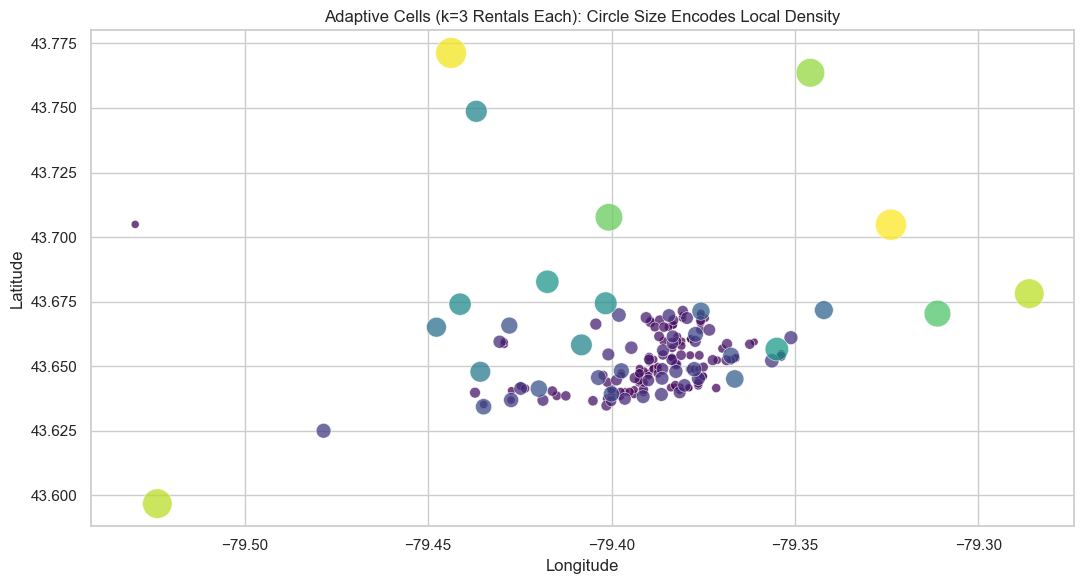

In [28]:
plt.figure(figsize=(11, 6))
plot_df = adaptive_grid.copy()

# Radius is the key density signal: sparse areas -> larger circles.
sns.scatterplot(
    data=plot_df,
    x='centroid_lon',
    y='centroid_lat',
    size='radius_m',
    hue='radius_m',
    palette='viridis',
    sizes=(30, 500),
    alpha=0.75,
    legend=False,
)

plt.title(f'Adaptive Cells (k={K_RENTALS_PER_CELL} Rentals Each): Circle Size Encodes Local Density')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

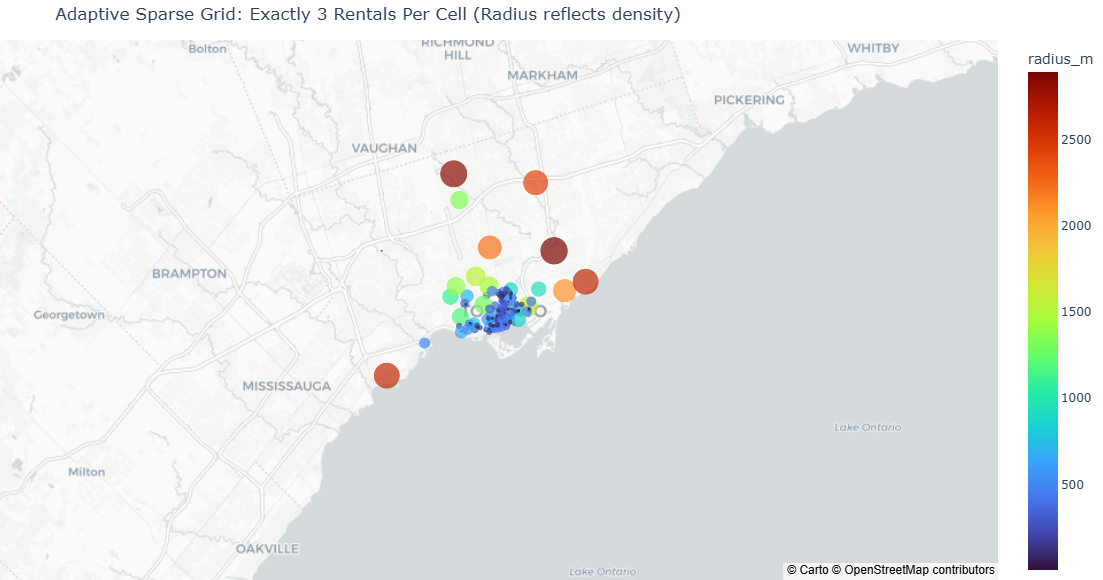

In [29]:
map_sample = adaptive_grid.sample(min(4000, len(adaptive_grid)), random_state=42)
fig = px.scatter_mapbox(
    map_sample,
    lat='centroid_lat',
    lon='centroid_lon',
    color='radius_m',
    size='radius_m',
    hover_data={
        'adaptive_cell_id': True,
        'rental_count': True,
        'radius_m': ':.1f',
        'crime_count_in_circle': True,
        'restaurant_count_in_circle': True,
        'subway_count_in_circle': True,
    },
    title=f'Adaptive Sparse Grid: Exactly {K_RENTALS_PER_CELL} Rentals Per Cell (Radius reflects density)',
    color_continuous_scale='Turbo',
    zoom=9.2,
    height=580,
)
fig.update_layout(mapbox_style='carto-positron', margin={'l': 0, 'r': 0, 't': 40, 'b': 0})
fig.show()

## Validation Checks

**Question:** Did preprocessing and sparse-grid creation complete with integrity?

**Method:** Assertions on coordinate validity, projected coordinates, point assignment completeness, and artifact existence.

**What we found:** Checks below must pass for this notebook execution to be valid.

**Why this matters for next-phase clustering:** It guarantees the grid foundation is technically sound before unsupervised modeling.


In [31]:
# coordinate validity after cleaning
assert valid_coord_mask(crime, 'Lat', 'Long').all()
assert valid_coord_mask(rent, 'Lat', 'Long').all()
assert valid_coord_mask(rest_venue, 'Restaurant Latitude', 'Restaurant Longitude').all()
assert valid_coord_mask(subway, 'latitude', 'longitude').all()

# projected coordinates must exist and be finite
for df in [crime_proj, rent_proj, rest_proj, subway_proj]:
    assert df[['x_m', 'y_m']].notna().all().all()
    assert np.isfinite(df[['x_m', 'y_m']].to_numpy()).all()

# adaptive-cell integrity
assert len(adaptive_grid) > 0
assert (adaptive_grid['rental_count'] == K_RENTALS_PER_CELL).all()
assert adaptive_grid[['radius_m', 'cell_area_km2']].gt(0).all().all()

# retained rental points consistency
expected_retained = len(rent_core) - len(leftover_rental_indices)
assert int(adaptive_grid['rental_count'].sum()) == int(expected_retained)


# non-overlap assignment integrity (each point counted once)
assert int(adaptive_grid['crime_count_in_circle'].sum()) == int(len(crime_proj))
assert int(adaptive_grid['restaurant_count_in_circle'].sum()) == int(len(rest_proj))
assert int(adaptive_grid['subway_count_in_circle'].sum()) == int(len(subway_proj))

# outputs
assert (OUTPUT_DIR / 'data_quality_audit.csv').exists()
assert (OUTPUT_DIR / 'preprocessing_drop_log.csv').exists()
assert adaptive_output.exists() and adaptive_output.stat().st_size > 0

validation = pd.DataFrame([
    {'check': 'rental_points_total', 'value': int(len(rent_core)), 'status': 'pass'},
    {'check': 'adaptive_cells_created', 'value': int(len(adaptive_grid)), 'status': 'pass'},
    {'check': 'rentals_per_cell_min', 'value': int(adaptive_grid['rental_count'].min()), 'status': 'pass'},
    {'check': 'rentals_per_cell_max', 'value': int(adaptive_grid['rental_count'].max()), 'status': 'pass'},
    {'check': 'leftover_rentals', 'value': int(len(leftover_rental_indices)), 'status': 'pass'},
    {'check': 'crime_count_no_overlap', 'value': int(adaptive_grid['crime_count_in_circle'].sum()), 'status': 'pass'},
    {'check': 'restaurant_count_no_overlap', 'value': int(adaptive_grid['restaurant_count_in_circle'].sum()), 'status': 'pass'},
    {'check': 'subway_count_no_overlap', 'value': int(adaptive_grid['subway_count_in_circle'].sum()), 'status': 'pass'},
])

validation

,check,value,status
0,rental_points_total,595,pass
1,adaptive_cells_created,196,pass
2,rentals_per_cell_min,3,pass
3,rentals_per_cell_max,3,pass
4,leftover_rentals,7,pass
5,crime_count_no_overlap,178892,pass
6,restaurant_count_no_overlap,6101,pass
7,subway_count_no_overlap,69,pass


## Phase 2 Handoff Notes

This notebook intentionally stops at adaptive spatial-unit construction.

Next phase should:
1. aggregate richer engineered features per adaptive cell,
2. normalize/transform features,
3. run clustering,
4. evaluate overlap/separation and spatial coherence.


In [33]:
elapsed_minutes = (time.time() - NOTEBOOK_START) / 60
print(f'Notebook runtime: {elapsed_minutes:.2f} minutes')
print('Saved artifacts:')
for p in sorted(OUTPUT_DIR.glob('*.csv')):
    print(' -', p)


Notebook runtime: 0.19 minutes
Saved artifacts:
 - ..\outputs\eda\adaptive_feature_engineered_k3.csv
 - ..\outputs\eda\adaptive_feature_matrix_scaled_k3.csv
 - ..\outputs\eda\adaptive_feature_rows_k3.csv
 - ..\outputs\eda\adaptive_sparse_grid_rentals_k3.csv
 - ..\outputs\eda\data_quality_audit.csv
 - ..\outputs\eda\dbscan_labels.csv
 - ..\outputs\eda\hdbscan_labels.csv
 - ..\outputs\eda\kmeans_labels_k4.csv
 - ..\outputs\eda\preprocessing_drop_log.csv


## Step 3: Feature Engineering for Clustering

This section creates clustering-ready features focused on neighbourhood profile insights (not location encoding):
- Density and ratio features (per-km2 and amenity/safety balance)
- One-hot encoding for tier columns (rent, safety, transit, food access)
- Frequency encoding for tier combinations to capture how common each profile is


### Why These Features Are Relevant Here

The goal is to understand neighbourhood profiles across rent, safety, transit, and food access tiers. So the encoding strategy is designed to make those tier patterns explicit and comparable.

- Density features (per_km2) normalize counts across variable-size adaptive cells.
- Ratio features expose trade-offs (for example amenities relative to crime) that raw counts can hide.
- Log features reduce the influence of extreme count hotspots.
- One-hot tier features make each tier directly interpretable in cluster profiles.
- Combo-frequency features represent how common or rare each tier combination is, which helps surface emerging vs typical profiles.
- Spatial/index IDs are kept for traceability only, not as encoding targets.


#### 1) Numeric Density, Ratio, and Log Features
Why this matters:
- crime_per_km2, restaurant_per_km2, subway_per_km2: comparable intensity across variable-size adaptive cells.
- amenity_to_crime_ratio, subway_to_crime_ratio: how much convenience exists relative to safety pressure.
- rent_to_amenity_ratio: affordability context against local offerings.
- log1p features: compresses extreme tails common in urban count data while preserving ordering.


In [37]:
fe = adaptive_grid.copy()
eps = 1e-6

fe['crime_per_km2'] = fe['crime_count_in_circle'] / (fe['cell_area_km2'] + eps)
fe['violent_crime_per_km2'] = fe['violent_crime_count_in_circle'] / (fe['cell_area_km2'] + eps)
fe['restaurant_per_km2'] = fe['restaurant_count_in_circle'] / (fe['cell_area_km2'] + eps)
fe['subway_per_km2'] = fe['subway_count_in_circle'] / (fe['cell_area_km2'] + eps)

fe['amenity_to_crime_ratio'] = fe['restaurant_count_in_circle'] / (fe['crime_count_in_circle'] + 1.0)
fe['subway_to_crime_ratio'] = fe['subway_count_in_circle'] / (fe['crime_count_in_circle'] + 1.0)
fe['rent_to_amenity_ratio'] = fe['mean_rent'] / (fe['restaurant_count_in_circle'] + 1.0)

for col in ['crime_count_in_circle', 'violent_crime_count_in_circle', 'restaurant_count_in_circle', 'subway_count_in_circle', 'radius_m', 'mean_rent', 'mean_price_per_bedroom']:
    fe[f'{col}_log1p'] = np.log1p(fe[col].clip(lower=0))

fe[['crime_per_km2', 'restaurant_per_km2', 'amenity_to_crime_ratio']].head(5)


,crime_per_km2,restaurant_per_km2,amenity_to_crime_ratio
0,28892.193961,3399.081642,0.116505
1,247782.339945,6542.107985,0.026316
2,24773.715957,599.364096,0.024000
3,0.000000,0.000000,0.000000
4,6930.629711,11551.049518,1.428571


#### 2) One-Hot Encoding for Low-Cardinality Tiers
Why this matters:
- rent_tier describes market level (lower to premium).
- safety_tier turns violent-crime ratio into interpretable risk bands.
- transit_tier and food_access_tier summarize access level instead of raw counts.
- One-hot keeps categories model-ready and avoids imposing fake numeric distance between labels.


In [39]:

# where rent_q1 is the lowest rent quartile and rent_q4 is the highest
fe['rent_tier'] = pd.qcut(fe['mean_rent'], q=4, labels=['rent_q1', 'rent_q2', 'rent_q3', 'rent_q4'], duplicates='drop')

# where safe <10% violent crime, moderate 10-25%, higher_risk >25%
# -0.01 was used just to ensure that 0% violent crime cases are included in the 'safe' tier
fe['safety_tier'] = pd.cut(fe['violent_crime_ratio_in_circle'], bins=[-0.01, 0.10, 0.25, 1.0], labels=['safe', 'moderate', 'higher_risk'])


fe['transit_tier'] = pd.cut(fe['subway_count_in_circle'], bins=[-0.01, 0.5, 1.5, 3.5, np.inf], labels=['none', 'low', 'medium', 'high'])

# where food_q1 is the lowest food access quartile and food_q4 is the highest
fe['food_access_tier'] = pd.qcut(fe['restaurant_count_in_circle'], q=4, labels=['food_q1', 'food_q2', 'food_q3', 'food_q4'], duplicates='drop')

low_card_cols = ['rent_tier', 'safety_tier', 'transit_tier', 'food_access_tier']
for c in low_card_cols:
    fe[c] = fe[c].astype('object').fillna('missing')

one_hot = pd.get_dummies(fe[low_card_cols], prefix=low_card_cols, dtype=int)
one_hot.head(5)


,rent_tier_rent_q1,rent_tier_rent_q2,rent_tier_rent_q3,rent_tier_rent_q4,safety_tier_higher_risk,safety_tier_safe,transit_tier_high,transit_tier_low,transit_tier_medium,transit_tier_none,food_access_tier_food_q1,food_access_tier_food_q2,food_access_tier_food_q3,food_access_tier_food_q4
0,0,1,0,0,1,0,0,0,0,1,0,0,1,0
1,0,1,0,0,1,0,0,0,0,1,0,1,0,0
2,0,1,0,0,1,0,0,0,0,1,0,1,0,0
3,0,1,0,0,0,1,0,0,0,1,1,0,0,0
4,0,0,1,0,1,0,0,0,0,1,0,0,1,0


#### 3) Frequency Encoding for Tier Combinations
Why this matters:
- Individual tiers are informative, but combinations (for example high transit + moderate safety) often define the actual neighbourhood profile.
- Frequency encoding on combinations captures how common each profile is across the city.
- This keeps the encoding compact and aligned with our insight goal.


In [41]:
tier_cols = ['rent_tier', 'safety_tier', 'transit_tier', 'food_access_tier']

combo_defs = {
    'rent_safety_combo': ['rent_tier', 'safety_tier'],
    'transit_food_combo': ['transit_tier', 'food_access_tier'],
    'rent_transit_combo': ['rent_tier', 'transit_tier'],
    'safety_transit_combo': ['safety_tier', 'transit_tier'],
    'all_tiers_combo': tier_cols,
}

tier_combo_freq = pd.DataFrame(index=fe.index)
for combo_name, cols in combo_defs.items():
    combo_key = fe[cols].astype(str).agg('|'.join, axis=1)
    combo_map = combo_key.value_counts(normalize=True)
    tier_combo_freq[f'{combo_name}_freq'] = combo_key.map(combo_map).astype(float)

fe = pd.concat([fe, tier_combo_freq], axis=1)
fe[[c for c in fe.columns if c.endswith('_combo_freq')]].head(5)


,rent_safety_combo_freq,transit_food_combo_freq,rent_transit_combo_freq,safety_transit_combo_freq,all_tiers_combo_freq
0,0.209184,0.219388,0.229592,0.658163,0.066327
1,0.209184,0.204082,0.229592,0.658163,0.045918
2,0.209184,0.204082,0.229592,0.658163,0.045918
3,0.045918,0.290816,0.229592,0.188776,0.040816
4,0.178571,0.219388,0.224490,0.658163,0.045918


#### 4) Build Final Feature Matrix (Pre-Scaling)
Why this matters:
- This step assembles engineered numeric features, one-hot tier columns, and combo-frequency columns in one model-ready table.
- We remove identifier and coordinate fields used for joins/traceability so clustering focuses on behavioural profile features.
- Scaling is done in the next dedicated section so the fitted scaler can be reused in the app.


In [43]:
drop_from_features = {
    'adaptive_cell_id', 'member_rental_idx', 'seed_grid_x', 'seed_grid_y',
    'spatial_key_1km', 'centroid_lon', 'centroid_lat', 'x_centroid', 'y_centroid'
}

numeric_candidates = [c for c in fe.columns if c not in drop_from_features and pd.api.types.is_numeric_dtype(fe[c])]
numeric_features = fe[numeric_candidates].replace([np.inf, -np.inf], np.nan).fillna(0.0)

feature_matrix = pd.concat([numeric_features, one_hot], axis=1)
feature_matrix = feature_matrix.loc[:, ~feature_matrix.columns.duplicated()].copy()

feature_output = OUTPUT_DIR / f'adaptive_feature_engineered_k{K_RENTALS_PER_CELL}.csv'
feature_row_output = OUTPUT_DIR / f'adaptive_feature_rows_k{K_RENTALS_PER_CELL}.csv'

feature_matrix.to_csv(feature_output, index=False)
fe.to_csv(feature_row_output, index=False)

print('Feature matrix prepared (not scaled yet).')
print(f'Rows: {len(feature_matrix):,} | Features: {feature_matrix.shape[1]:,}')
print('Saved:')
print(' -', feature_output)
print(' -', feature_row_output)
feature_matrix.head(5)


Feature matrix prepared (not scaled yet).
Rows: 196 | Features: 49
Saved:
 - ..\outputs\eda\adaptive_feature_engineered_k3.csv
 - ..\outputs\eda\adaptive_feature_rows_k3.csv


,rental_count,growth_rings,seed_local_k_radius_m,radius_m,mean_rent,median_rent,mean_price_per_bedroom,cell_area_km2,crime_count_in_circle,violent_crime_count_in_circle,violent_crime_ratio_in_circle,restaurant_count_in_circle,subway_count_in_circle,crime_assignment_median_dist_m,restaurant_assignment_median_dist_m,subway_assignment_median_dist_m,crime_per_km2,violent_crime_per_km2,restaurant_per_km2,subway_per_km2,amenity_to_crime_ratio,subway_to_crime_ratio,rent_to_amenity_ratio,crime_count_in_circle_log1p,violent_crime_count_in_circle_log1p,restaurant_count_in_circle_log1p,subway_count_in_circle_log1p,radius_m_log1p,mean_rent_log1p,mean_price_per_bedroom_log1p,rent_safety_combo_freq,transit_food_combo_freq,rent_transit_combo_freq,safety_transit_combo_freq,all_tiers_combo_freq,rent_tier_rent_q1,rent_tier_rent_q2,rent_tier_rent_q3,rent_tier_rent_q4,safety_tier_higher_risk,safety_tier_safe,transit_tier_high,transit_tier_low,transit_tier_medium,transit_tier_none,food_access_tier_food_q1,food_access_tier_food_q2,food_access_tier_food_q3,food_access_tier_food_q4
0,3,0,33.517635,33.517635,2150.000000,2100.0,1733.333333,0.003529,102,70,0.686275,12,0,2220.414717,679.669729,1420.642442,28892.193961,19827.976248,3399.081642,0.0,0.116505,0.0,165.384615,4.634729,4.262680,2.564949,0.0,3.541470,7.673688,7.458378,0.209184,0.219388,0.229592,0.658163,0.066327,0,1,0,0,1,0,0,0,0,1,0,0,1,0
1,3,0,19.721210,19.721210,1983.333333,2000.0,1983.333333,0.001222,303,213,0.702970,8,0,2220.414717,679.669729,1420.642442,247782.339945,174183.625110,6542.107985,0.0,0.026316,0.0,220.370370,5.717028,5.365976,2.197225,0.0,3.031158,7.593038,7.593038,0.209184,0.204082,0.229592,0.658163,0.045918,0,1,0,0,1,0,0,0,0,1,0,1,0,0
2,3,0,39.911398,39.911398,2033.333333,2050.0,2033.333333,0.005004,124,77,0.620968,3,0,2220.414717,679.669729,1420.642442,24773.715957,15383.678457,599.364096,0.0,0.024000,0.0,508.333333,4.828314,4.356709,1.386294,0.0,3.711409,7.617923,7.617923,0.209184,0.204082,0.229592,0.658163,0.045918,0,1,0,0,1,0,0,0,0,1,0,1,0,0
3,3,0,33.517635,33.517635,2113.333333,2100.0,2113.333333,0.003529,0,0,0.000000,0,0,2220.414717,679.669729,1420.642442,0.000000,0.000000,0.000000,0.0,0.000000,0.0,2113.333333,0.000000,0.000000,0.000000,0.0,3.541470,7.656495,7.656495,0.045918,0.290816,0.229592,0.188776,0.040816,0,1,0,0,0,1,0,0,0,1,1,0,0,0
4,3,0,16.590649,16.590649,2483.333333,2550.0,2483.333333,0.000865,6,6,1.000000,10,0,2220.414717,679.669729,1420.642442,6930.629711,6930.629711,11551.049518,0.0,1.428571,0.0,225.757576,1.945910,1.945910,2.397895,0.0,2.867367,7.817760,7.817760,0.178571,0.219388,0.224490,0.658163,0.045918,0,0,1,0,1,0,0,0,0,1,0,0,1,0


#### 5) Scale Features with StandardScaler and Save Scaler for App
Why StandardScaler specifically:
- StandardScaler applies z-score normalization: each feature becomes (value - mean) / std.
- This centers features around 0 and gives them unit variance, so rent, density, ratios, and encoded columns are on a comparable scale.

Why scaling is important for this notebook:
- Our next step is clustering, and common clustering methods (especially KMeans and distance-based approaches) use Euclidean distance.
- Without scaling, large-magnitude variables (for example rent) dominate distance calculations and can hide safety/accessibility signals.
- With scaling, clusters reflect multi-factor neighbourhood profiles instead of mainly whichever feature has the largest numeric range.

Why saving the fitted scaler matters for the app:
- The app must transform incoming data with the exact same means/stds used during analysis/training.
- Re-fitting a new scaler in production would shift feature space and make cluster assignments inconsistent with notebook results.


In [45]:
from sklearn.preprocessing import StandardScaler
import joblib

scaler = StandardScaler()
feature_matrix_scaled = pd.DataFrame(
    scaler.fit_transform(feature_matrix),
    columns=feature_matrix.columns,
    index=feature_matrix.index,
)

scaled_output = OUTPUT_DIR / f'adaptive_feature_matrix_scaled_k{K_RENTALS_PER_CELL}.csv'
app_artifact_dir = OUTPUT_DIR.parent / 'app'
app_artifact_dir.mkdir(parents=True, exist_ok=True)
scaler_output = app_artifact_dir / f'adaptive_standard_scaler_k{K_RENTALS_PER_CELL}.joblib'

feature_matrix_scaled.to_csv(scaled_output, index=False)
joblib.dump(scaler, scaler_output)

print('Scaling complete.')
print('Saved:')
print(' -', scaled_output)
print(' -', scaler_output)
feature_matrix_scaled.head(5)


Scaling complete.
Saved:
 - ..\outputs\eda\adaptive_feature_matrix_scaled_k3.csv
 - ..\outputs\app\adaptive_standard_scaler_k3.joblib


,rental_count,growth_rings,seed_local_k_radius_m,radius_m,mean_rent,median_rent,mean_price_per_bedroom,cell_area_km2,crime_count_in_circle,violent_crime_count_in_circle,violent_crime_ratio_in_circle,restaurant_count_in_circle,subway_count_in_circle,crime_assignment_median_dist_m,restaurant_assignment_median_dist_m,subway_assignment_median_dist_m,crime_per_km2,violent_crime_per_km2,restaurant_per_km2,subway_per_km2,amenity_to_crime_ratio,subway_to_crime_ratio,rent_to_amenity_ratio,crime_count_in_circle_log1p,violent_crime_count_in_circle_log1p,restaurant_count_in_circle_log1p,subway_count_in_circle_log1p,radius_m_log1p,mean_rent_log1p,mean_price_per_bedroom_log1p,rent_safety_combo_freq,transit_food_combo_freq,rent_transit_combo_freq,safety_transit_combo_freq,all_tiers_combo_freq,rent_tier_rent_q1,rent_tier_rent_q2,rent_tier_rent_q3,rent_tier_rent_q4,safety_tier_higher_risk,safety_tier_safe,transit_tier_high,transit_tier_low,transit_tier_medium,transit_tier_none,food_access_tier_food_q1,food_access_tier_food_q2,food_access_tier_food_q3,food_access_tier_food_q4
0,0.0,-0.529513,-0.502067,-0.502067,-0.277101,-0.359807,-0.369780,-0.289876,-0.248870,-0.253328,0.595759,-0.293357,-0.337931,-9.094947e-13,1.136868e-13,2.273737e-13,-0.098940,-0.096730,0.126315,-0.166944,-0.044262,-0.076142,-0.636297,0.068758,0.070656,0.243790,-0.390475,-0.907521,-0.163076,-0.256190,0.573567,0.259378,0.622386,0.711487,1.189888,-0.57735,1.708801,-0.569495,-0.57735,0.490414,-0.490414,-0.19245,-0.26653,-0.231869,0.425115,-0.640369,-0.514311,1.708801,-0.569495
1,0.0,-0.529513,-0.528245,-0.528245,-0.612232,-0.546998,0.254173,-0.290459,-0.187168,-0.178657,0.655473,-0.354704,-0.337931,-9.094947e-13,1.136868e-13,2.273737e-13,0.125455,0.168154,0.449335,-0.166944,-0.133047,-0.076142,-0.580331,0.489138,0.525187,0.022544,-0.390475,-1.292251,-0.516918,0.341715,0.573567,0.079949,0.622386,0.711487,0.122529,-0.57735,1.708801,-0.569495,-0.57735,0.490414,-0.490414,-0.19245,-0.26653,-0.231869,0.425115,-0.640369,1.944348,-0.585206,-0.569495
2,0.0,-0.529513,-0.489934,-0.489934,-0.511693,-0.453402,0.378963,-0.289504,-0.242116,-0.249673,0.362184,-0.431389,-0.337931,-9.094947e-13,1.136868e-13,2.273737e-13,-0.103162,-0.104356,-0.161422,-0.166944,-0.135327,-0.076142,-0.287236,0.143949,0.109393,-0.465363,-0.390475,-0.779403,-0.407737,0.452208,0.573567,0.079949,0.622386,0.711487,0.122529,-0.57735,1.708801,-0.569495,-0.57735,0.490414,-0.490414,-0.19245,-0.26653,-0.231869,0.425115,-0.640369,1.944348,-0.585206,-0.569495
3,0.0,-0.529513,-0.502067,-0.502067,-0.350830,-0.359807,0.578628,-0.289876,-0.280181,-0.289880,-1.858759,-0.477399,-0.337931,-9.094947e-13,1.136868e-13,2.273737e-13,-0.128559,-0.130756,-0.223021,-0.166944,-0.158953,-0.076142,1.346372,-1.731437,-1.685465,-1.299445,-0.390475,-0.907521,-0.238510,0.623470,-2.083311,1.096711,0.622386,-1.126555,-0.144311,-0.57735,1.708801,-0.569495,-0.57735,-2.039092,2.039092,-0.19245,-0.26653,-0.231869,0.425115,1.561601,-0.514311,-0.585206,-0.569495
4,0.0,-0.529513,-0.534186,-0.534186,0.393159,0.482551,1.502078,-0.290549,-0.278339,-0.286747,1.717825,-0.324031,-0.337931,-9.094947e-13,1.136868e-13,2.273737e-13,-0.121454,-0.118862,0.964122,-0.166944,1.247385,-0.076142,-0.574848,-0.975618,-0.883797,0.143280,-0.390475,-1.415735,0.469023,1.339504,0.075402,0.259378,0.552278,0.711487,0.122529,-0.57735,-0.585206,1.755942,-0.57735,0.490414,-0.490414,-0.19245,-0.26653,-0.231869,0.425115,-0.640369,-0.514311,1.708801,-0.569495


## Phase 3 Hand Off Notes
This notebook intentionally stops after StandardScaler()

The next sections should:
1. Perform feature selection
2. PCA
3. K-Means + DBSCAN + HDBSCAN
4. Evaluation

## Step 4: Feature Selection (Cluster-Stability Permutation Importance)

**Question:** Which features actually contribute to meaningful clustering structure, and which are noise?

**Method:**
- Since this is a **pure unsupervised** workflow (no target/label column), traditional supervised feature importance (e.g., Random Forest impurity) is not valid.
- Instead, we use **cluster-stability permutation importance**:
  1. Fit a baseline KMeans on the scaled feature matrix and compute the silhouette score.
  2. For each feature, randomly permute its values (breaking its relationship with other features) and re-score.
  3. Importance = mean drop in silhouette score when that feature is permuted.
  4. Features that cause a large silhouette drop are important to cluster structure; those with zero or negative drop are noise.
- Selection rule: **keep features until cumulative normalized importance reaches 90%** (configurable).

**Why this matters for clustering:** Removing noisy features improves cluster separation, reduces the curse of dimensionality, and makes cluster profiles more interpretable.

**Limitations of this approach (transparency):**
- Importance is measured relative to a specific k (number of clusters) and may shift if k changes.
- Correlated features share importance; dropping one may inflate the other's contribution.
- Permutation breaks marginal but also conditional structure, so importance is approximate.
- Results should be treated as a ranking heuristic, not ground truth.

In [48]:
import json
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ── Configuration (all tuneable) ──────────────────────────────────
FEATURE_SEL_K = 5            # KMeans k for stability measurement
N_PERMUTATIONS = 10          # repeats per feature (variance reduction)
CUMULATIVE_IMPORTANCE_THRESHOLD = 0.90
FEATURE_SEL_SEED = 42
MIN_FEATURES_KEEP = 5        # safety floor

REPORT_FIG_DIR = Path('../reports/figures')
FEATURE_SEL_DIR = Path('../outputs/feature_selection')
REPORT_FIG_DIR.mkdir(parents=True, exist_ok=True)
FEATURE_SEL_DIR.mkdir(parents=True, exist_ok=True)

# ── Inputs ────────────────────────────────────────────────────────
X_scaled = feature_matrix_scaled.copy()
feature_names = X_scaled.columns.tolist()

print(f'Input feature matrix shape: {X_scaled.shape}')
print(f'Total features: {len(feature_names)}')
print(f'All features numeric: {all(pd.api.types.is_numeric_dtype(X_scaled[c]) for c in feature_names)}')
print(f'Target/label column: None (unsupervised workflow)')


def run_feature_selection(
    X: pd.DataFrame,
    k: int = FEATURE_SEL_K,
    n_permutations: int = N_PERMUTATIONS,
    cumulative_threshold: float = CUMULATIVE_IMPORTANCE_THRESHOLD,
    min_keep: int = MIN_FEATURES_KEEP,
    random_state: int = FEATURE_SEL_SEED,
) -> tuple[pd.DataFrame, list[str]]:
    """Cluster-stability permutation importance for unsupervised feature selection.

    Returns (importance_df, selected_feature_names).
    """
    cols = X.columns.tolist()
    vals = X.values.copy()

    km = KMeans(n_clusters=k, n_init=10, random_state=random_state)
    baseline_labels = km.fit_predict(vals)
    baseline_sil = silhouette_score(vals, baseline_labels)
    print(f'\nBaseline KMeans (k={k}) silhouette: {baseline_sil:.4f}')

    importances = {}
    for feat_idx, feat_name in enumerate(cols):
        drops = []
        for perm_i in range(n_permutations):
            X_perm = vals.copy()
            rng = np.random.RandomState(random_state + perm_i)
            X_perm[:, feat_idx] = rng.permutation(X_perm[:, feat_idx])
            perm_labels = km.predict(X_perm)
            perm_sil = silhouette_score(X_perm, perm_labels)
            drops.append(baseline_sil - perm_sil)
        importances[feat_name] = float(np.mean(drops))

    imp_df = (
        pd.DataFrame({'feature': list(importances.keys()),
                       'importance': list(importances.values())})
        .sort_values('importance', ascending=False)
        .reset_index(drop=True)
    )

    total_positive = imp_df['importance'].clip(lower=0).sum()
    imp_df['importance_normalized'] = imp_df['importance'].clip(lower=0) / max(total_positive, 1e-12)
    imp_df['cumulative_importance'] = imp_df['importance_normalized'].cumsum()

    mask = imp_df['cumulative_importance'].shift(1, fill_value=0.0) < cumulative_threshold
    selected = imp_df.loc[mask, 'feature'].tolist()
    if len(selected) < min_keep:
        selected = imp_df['feature'].head(min_keep).tolist()

    return imp_df, selected


importance_df, selected_features = run_feature_selection(X_scaled)

print(f'\n── Selection summary ──')
print(f'Selection rule: cumulative importance >= {CUMULATIVE_IMPORTANCE_THRESHOLD}')
print(f'Features kept : {len(selected_features)} / {len(feature_names)}')
print(f'Features dropped: {len(feature_names) - len(selected_features)}')
print(f'\nTop 10 features by importance:')
importance_df.head(10)

Input feature matrix shape: (196, 49)
Total features: 49
All features numeric: True
Target/label column: None (unsupervised workflow)

Baseline KMeans (k=5) silhouette: 0.3413

── Selection summary ──
Selection rule: cumulative importance >= 0.9
Features kept : 31 / 49
Features dropped: 18

Top 10 features by importance:


,feature,importance,importance_normalized,cumulative_importance
0,safety_tier_safe,0.036751,0.070424,0.070424
1,safety_tier_higher_risk,0.036751,0.070424,0.140849
2,rent_safety_combo_freq,0.032802,0.062856,0.203705
3,violent_crime_ratio_in_circle,0.029943,0.057378,0.261083
4,safety_transit_combo_freq,0.028099,0.053844,0.314927
5,crime_count_in_circle_log1p,0.023823,0.045651,0.360578
6,violent_crime_count_in_circle_log1p,0.022411,0.042944,0.403522
7,rent_to_amenity_ratio,0.019421,0.037215,0.440738
8,food_access_tier_food_q1,0.017108,0.032782,0.473520
9,transit_tier_low,0.016797,0.032188,0.505708


Saved: ..\reports\figures\feature_importance.png


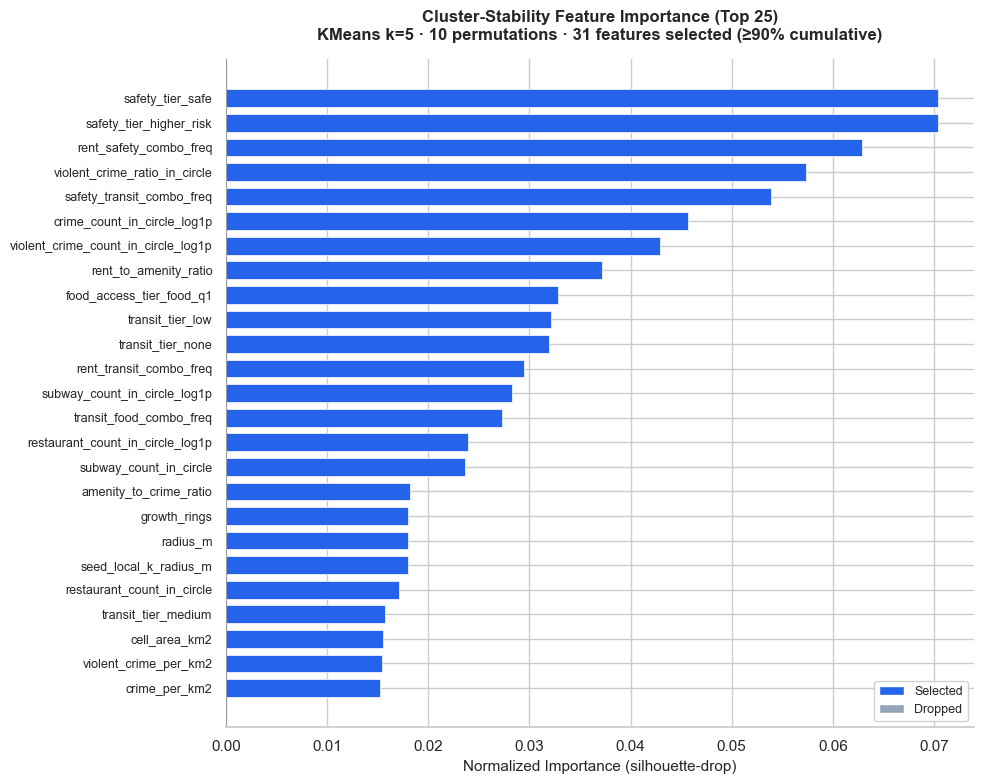

In [49]:
# ── Slide-ready feature importance bar chart ──────────────────────

TOP_K_DISPLAY = min(25, len(importance_df))
plot_df = importance_df.head(TOP_K_DISPLAY).copy()
is_selected = plot_df['feature'].isin(selected_features)

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#2563eb' if sel else '#94a3b8' for sel in is_selected]

bars = ax.barh(
    y=np.arange(TOP_K_DISPLAY)[::-1],
    width=plot_df['importance_normalized'].values,
    color=colors,
    edgecolor='white',
    linewidth=0.5,
    height=0.72,
)

ax.set_yticks(np.arange(TOP_K_DISPLAY)[::-1])
ax.set_yticklabels(plot_df['feature'].values, fontsize=9)
ax.set_xlabel('Normalized Importance (silhouette-drop)', fontsize=11)
ax.set_title(
    f'Cluster-Stability Feature Importance (Top {TOP_K_DISPLAY})\n'
    f'KMeans k={FEATURE_SEL_K} · {N_PERMUTATIONS} permutations · '
    f'{len(selected_features)} features selected (≥{CUMULATIVE_IMPORTANCE_THRESHOLD:.0%} cumulative)',
    fontsize=12, fontweight='bold', pad=14,
)
ax.axvline(0, color='grey', linewidth=0.5)

from matplotlib.patches import Patch
ax.legend(
    handles=[Patch(facecolor='#2563eb', label='Selected'),
             Patch(facecolor='#94a3b8', label='Dropped')],
    loc='lower right', fontsize=9, framealpha=0.9,
)

sns.despine(left=True)
plt.tight_layout()

fig_path = REPORT_FIG_DIR / 'feature_importance.png'
fig.savefig(fig_path, dpi=200, bbox_inches='tight')
print(f'Saved: {fig_path}')
plt.show()

In [50]:
# ── Save artifacts and build filtered matrix ──────────────────────

selected_features_path = FEATURE_SEL_DIR / 'selected_features.json'
importance_csv_path = FEATURE_SEL_DIR / 'feature_importance.csv'

with open(selected_features_path, 'w') as f:
    json.dump({
        'selected_features': selected_features,
        'selection_method': 'cluster_stability_permutation_importance',
        'params': {
            'kmeans_k': FEATURE_SEL_K,
            'n_permutations': N_PERMUTATIONS,
            'cumulative_threshold': CUMULATIVE_IMPORTANCE_THRESHOLD,
            'random_state': FEATURE_SEL_SEED,
        },
        'total_features_before': len(feature_names),
        'total_features_after': len(selected_features),
    }, f, indent=2)

importance_df.to_csv(importance_csv_path, index=False)

feature_matrix_selected = feature_matrix_scaled[selected_features].copy()

selected_matrix_path = FEATURE_SEL_DIR / f'feature_matrix_selected_k{K_RENTALS_PER_CELL}.csv'
feature_matrix_selected.to_csv(selected_matrix_path, index=False)

print('── Artifacts saved ──')
print(f'  Selected features list : {selected_features_path}')
print(f'  Full importance table  : {importance_csv_path}')
print(f'  Filtered feature matrix: {selected_matrix_path}')
print(f'\n── Before / After ──')
print(f'  Before: {X_scaled.shape[0]} rows × {X_scaled.shape[1]} features')
print(f'  After : {feature_matrix_selected.shape[0]} rows × {feature_matrix_selected.shape[1]} features')
print(f'\n── Reproducibility ──')
print(f'  random_state = {FEATURE_SEL_SEED}')
print(f'  KMeans n_init = 10')

feature_matrix_selected.head(5)

── Artifacts saved ──
  Selected features list : ..\outputs\feature_selection\selected_features.json
  Full importance table  : ..\outputs\feature_selection\feature_importance.csv
  Filtered feature matrix: ..\outputs\feature_selection\feature_matrix_selected_k3.csv

── Before / After ──
  Before: 196 rows × 49 features
  After : 196 rows × 31 features

── Reproducibility ──
  random_state = 42
  KMeans n_init = 10


,safety_tier_safe,safety_tier_higher_risk,rent_safety_combo_freq,violent_crime_ratio_in_circle,safety_transit_combo_freq,crime_count_in_circle_log1p,violent_crime_count_in_circle_log1p,rent_to_amenity_ratio,food_access_tier_food_q1,transit_tier_low,transit_tier_none,rent_transit_combo_freq,subway_count_in_circle_log1p,transit_food_combo_freq,restaurant_count_in_circle_log1p,subway_count_in_circle,amenity_to_crime_ratio,growth_rings,radius_m,seed_local_k_radius_m,restaurant_count_in_circle,transit_tier_medium,cell_area_km2,violent_crime_per_km2,crime_per_km2,all_tiers_combo_freq,transit_tier_high,restaurant_per_km2,radius_m_log1p,violent_crime_count_in_circle,crime_count_in_circle
0,-0.490414,0.490414,0.573567,0.595759,0.711487,0.068758,0.070656,-0.636297,-0.640369,-0.26653,0.425115,0.622386,-0.390475,0.259378,0.243790,-0.337931,-0.044262,-0.529513,-0.502067,-0.502067,-0.293357,-0.231869,-0.289876,-0.096730,-0.098940,1.189888,-0.19245,0.126315,-0.907521,-0.253328,-0.248870
1,-0.490414,0.490414,0.573567,0.655473,0.711487,0.489138,0.525187,-0.580331,-0.640369,-0.26653,0.425115,0.622386,-0.390475,0.079949,0.022544,-0.337931,-0.133047,-0.529513,-0.528245,-0.528245,-0.354704,-0.231869,-0.290459,0.168154,0.125455,0.122529,-0.19245,0.449335,-1.292251,-0.178657,-0.187168
2,-0.490414,0.490414,0.573567,0.362184,0.711487,0.143949,0.109393,-0.287236,-0.640369,-0.26653,0.425115,0.622386,-0.390475,0.079949,-0.465363,-0.337931,-0.135327,-0.529513,-0.489934,-0.489934,-0.431389,-0.231869,-0.289504,-0.104356,-0.103162,0.122529,-0.19245,-0.161422,-0.779403,-0.249673,-0.242116
3,2.039092,-2.039092,-2.083311,-1.858759,-1.126555,-1.731437,-1.685465,1.346372,1.561601,-0.26653,0.425115,0.622386,-0.390475,1.096711,-1.299445,-0.337931,-0.158953,-0.529513,-0.502067,-0.502067,-0.477399,-0.231869,-0.289876,-0.130756,-0.128559,-0.144311,-0.19245,-0.223021,-0.907521,-0.289880,-0.280181
4,-0.490414,0.490414,0.075402,1.717825,0.711487,-0.975618,-0.883797,-0.574848,-0.640369,-0.26653,0.425115,0.552278,-0.390475,0.259378,0.143280,-0.337931,1.247385,-0.529513,-0.534186,-0.534186,-0.324031,-0.231869,-0.290549,-0.118862,-0.121454,0.122529,-0.19245,0.964122,-1.415735,-0.286747,-0.278339


## Step 5: Dimensionality Reduction (PCA + UMAP)

**Question:** Do the selected features reveal separable cluster structure in 2D?

**Method:**
1. **Standardize** the selected features (already scaled via StandardScaler in Step 3, reused here).
2. **PCA** — linear projection that maximizes explained variance. We report the variance explained by each component and produce a 2D scatter.
3. **UMAP** — non-linear manifold embedding that preserves local neighbourhood structure. Better at revealing non-convex cluster shapes.

**Why PCA first:**
- PCA is deterministic (no random initialization beyond sign flips), cheap, and tells us how much variance is concentrated in the first few axes.
- If the first two PCs capture ≥50% variance, linear structure alone may be sufficient.

**Why UMAP second:**
- UMAP often reveals structure that PCA cannot (e.g., non-linear manifolds, nested clusters).
- It is the standard pre-clustering visualization in modern ML workflows.

**Plotting note:** No cluster labels exist yet (clustering is the next phase), so both plots are labelled "pre-clustering embedding." If cluster labels were available they would be overlaid automatically.

── PCA Explained Variance ──
  PC 1: 0.4054  (cumulative: 0.4054)
  PC 2: 0.1907  (cumulative: 0.5961)
  PC 3: 0.1113  (cumulative: 0.7074)
  PC 4: 0.0837  (cumulative: 0.7911)
  PC 5: 0.0445  (cumulative: 0.8356)
  PC 6: 0.0383  (cumulative: 0.8738)
  PC 7: 0.0299  (cumulative: 0.9038)
  PC 8: 0.0276  (cumulative: 0.9314)
  PC 9: 0.0210  (cumulative: 0.9524)
  PC10: 0.0143  (cumulative: 0.9667)

First 2 PCs explain 59.61% of total variance.

Saved: ..\reports\figures\pca_2d.png


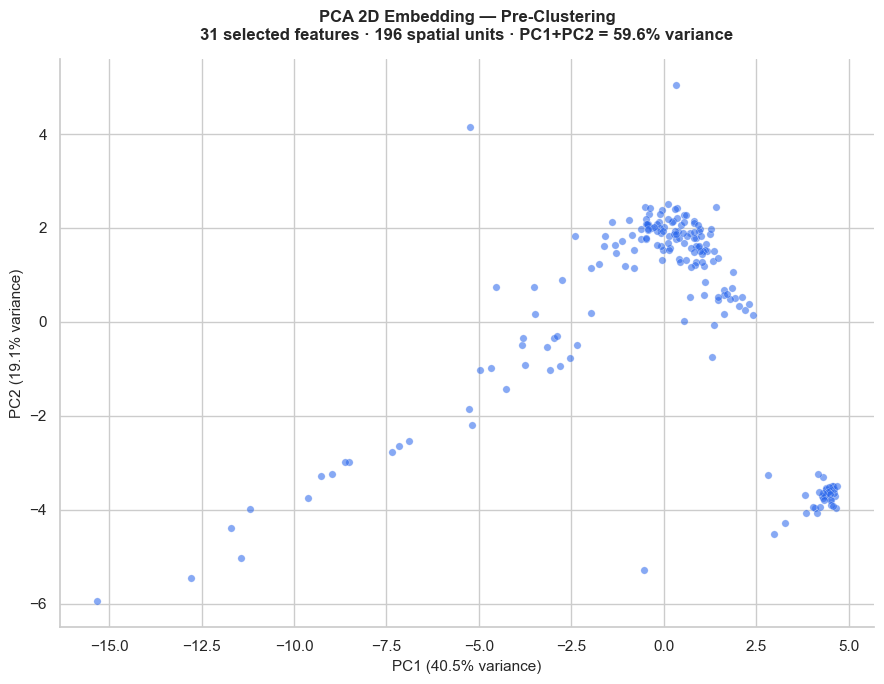

In [52]:
from sklearn.decomposition import PCA

# ── Configuration ─────────────────────────────────────────────────
PCA_N_COMPONENTS_REPORT = min(10, feature_matrix_selected.shape[1])
PCA_RANDOM_STATE = 42

# ── Fit PCA ───────────────────────────────────────────────────────

def run_pca(X: pd.DataFrame, n_components: int = PCA_N_COMPONENTS_REPORT,
            random_state: int = PCA_RANDOM_STATE) -> tuple[PCA, np.ndarray]:
    """Fit PCA and return (fitted model, 2D coordinates)."""
    pca = PCA(n_components=n_components, random_state=random_state)
    coords = pca.fit_transform(X.values)
    return pca, coords


pca_model, pca_coords = run_pca(feature_matrix_selected)

evr = pca_model.explained_variance_ratio_
print('── PCA Explained Variance ──')
for i, v in enumerate(evr):
    cum = evr[:i+1].sum()
    print(f'  PC{i+1:2d}: {v:.4f}  (cumulative: {cum:.4f})')

print(f'\nFirst 2 PCs explain {evr[:2].sum():.2%} of total variance.')

# ── 2D Scatter ────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(9, 7))
scatter = ax.scatter(
    pca_coords[:, 0], pca_coords[:, 1],
    c='#2563eb', alpha=0.55, s=28, edgecolors='white', linewidths=0.3,
)
ax.set_xlabel(f'PC1 ({evr[0]:.1%} variance)', fontsize=11)
ax.set_ylabel(f'PC2 ({evr[1]:.1%} variance)', fontsize=11)
ax.set_title(
    f'PCA 2D Embedding — Pre-Clustering\n'
    f'{feature_matrix_selected.shape[1]} selected features · '
    f'{feature_matrix_selected.shape[0]} spatial units · '
    f'PC1+PC2 = {evr[:2].sum():.1%} variance',
    fontsize=12, fontweight='bold', pad=14,
)
sns.despine()
plt.tight_layout()

pca_fig_path = REPORT_FIG_DIR / 'pca_2d.png'
fig.savefig(pca_fig_path, dpi=200, bbox_inches='tight')
print(f'\nSaved: {pca_fig_path}')
plt.show()

Saved: ..\reports\figures\umap_2d.png


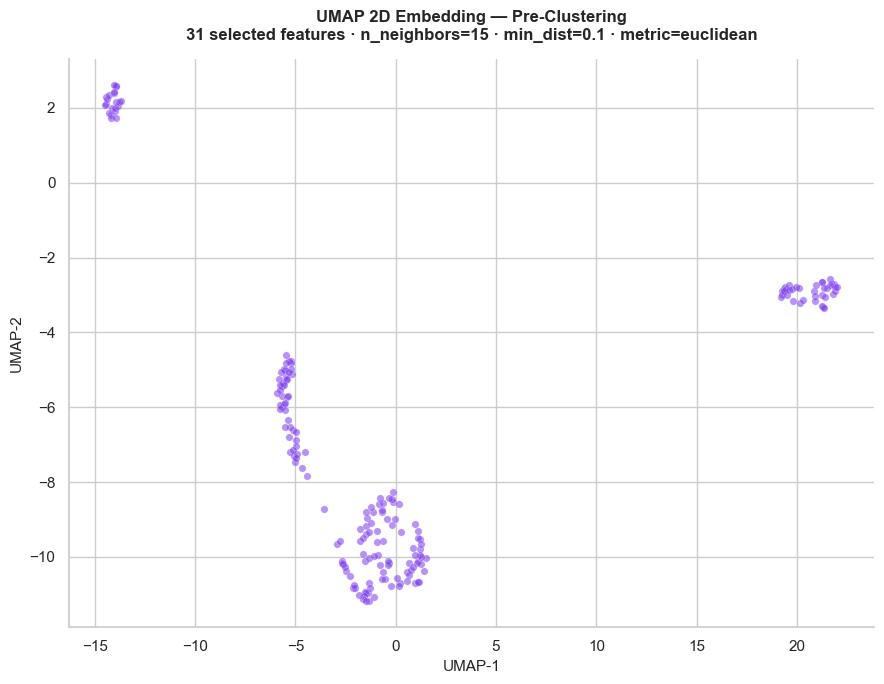

In [53]:
from umap.umap_ import UMAP as UMAPReducer

# ── Configuration (all tuneable) ──────────────────────────────────
UMAP_N_NEIGHBORS = 15
UMAP_MIN_DIST = 0.1
UMAP_METRIC = 'euclidean'
UMAP_RANDOM_STATE = 42


def run_umap(X: pd.DataFrame, n_neighbors: int = UMAP_N_NEIGHBORS,
             min_dist: float = UMAP_MIN_DIST, metric: str = UMAP_METRIC,
             random_state: int = UMAP_RANDOM_STATE) -> np.ndarray:
    """Fit UMAP and return 2D coordinates."""
    reducer = UMAPReducer(
        n_components=2,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
    )
    return reducer.fit_transform(X.values)


umap_coords = run_umap(feature_matrix_selected)

# ── 2D Scatter ────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(9, 7))
scatter = ax.scatter(
    umap_coords[:, 0], umap_coords[:, 1],
    c='#7c3aed', alpha=0.55, s=28, edgecolors='white', linewidths=0.3,
)
ax.set_xlabel('UMAP-1', fontsize=11)
ax.set_ylabel('UMAP-2', fontsize=11)
ax.set_title(
    f'UMAP 2D Embedding — Pre-Clustering\n'
    f'{feature_matrix_selected.shape[1]} selected features · '
    f'n_neighbors={UMAP_N_NEIGHBORS} · min_dist={UMAP_MIN_DIST} · '
    f'metric={UMAP_METRIC}',
    fontsize=12, fontweight='bold', pad=14,
)
sns.despine()
plt.tight_layout()

umap_fig_path = REPORT_FIG_DIR / 'umap_2d.png'
fig.savefig(umap_fig_path, dpi=200, bbox_inches='tight')
print(f'Saved: {umap_fig_path}')
plt.show()

In [54]:
print('═' * 60)
print('  DIMENSIONALITY REDUCTION — VALIDATION SUMMARY')
print('═' * 60)

print(f'\n  Input matrix      : {feature_matrix_selected.shape[0]} rows × {feature_matrix_selected.shape[1]} features')
print(f'  Features (from)   : {X_scaled.shape[1]} total → {feature_matrix_selected.shape[1]} selected')

print(f'\n  ── PCA ──')
print(f'  Components fitted : {PCA_N_COMPONENTS_REPORT}')
print(f'  PC1 variance      : {evr[0]:.2%}')
print(f'  PC2 variance      : {evr[1]:.2%}')
print(f'  PC1+PC2 cumulative: {evr[:2].sum():.2%}')
print(f'  Figure saved      : {pca_fig_path}')

print(f'\n  ── UMAP ──')
print(f'  n_neighbors       : {UMAP_N_NEIGHBORS}')
print(f'  min_dist          : {UMAP_MIN_DIST}')
print(f'  metric            : {UMAP_METRIC}')
print(f'  random_state      : {UMAP_RANDOM_STATE}')
print(f'  Figure saved      : {umap_fig_path}')

print(f'\n  ── Reproducibility ──')
print(f'  PCA random_state  : {PCA_RANDOM_STATE}')
print(f'  UMAP random_state : {UMAP_RANDOM_STATE}')

print(f'\n  ── Files changed/added ──')
print(f'  Modified: notebooks/toronto_housing_clustering_baseline.ipynb')
print(f'  Added   : reports/figures/pca_2d.png')
print(f'  Added   : reports/figures/umap_2d.png')
print('═' * 60)

════════════════════════════════════════════════════════════
  DIMENSIONALITY REDUCTION — VALIDATION SUMMARY
════════════════════════════════════════════════════════════

  Input matrix      : 196 rows × 31 features
  Features (from)   : 49 total → 31 selected

  ── PCA ──
  Components fitted : 10
  PC1 variance      : 40.54%
  PC2 variance      : 19.07%
  PC1+PC2 cumulative: 59.61%
  Figure saved      : ..\reports\figures\pca_2d.png

  ── UMAP ──
  n_neighbors       : 15
  min_dist          : 0.1
  metric            : euclidean
  random_state      : 42
  Figure saved      : ..\reports\figures\umap_2d.png

  ── Reproducibility ──
  PCA random_state  : 42
  UMAP random_state : 42

  ── Files changed/added ──
  Modified: notebooks/toronto_housing_clustering_baseline.ipynb
  Added   : reports/figures/pca_2d.png
  Added   : reports/figures/umap_2d.png
════════════════════════════════════════════════════════════


# Clustering 

## Method 1: K-Means

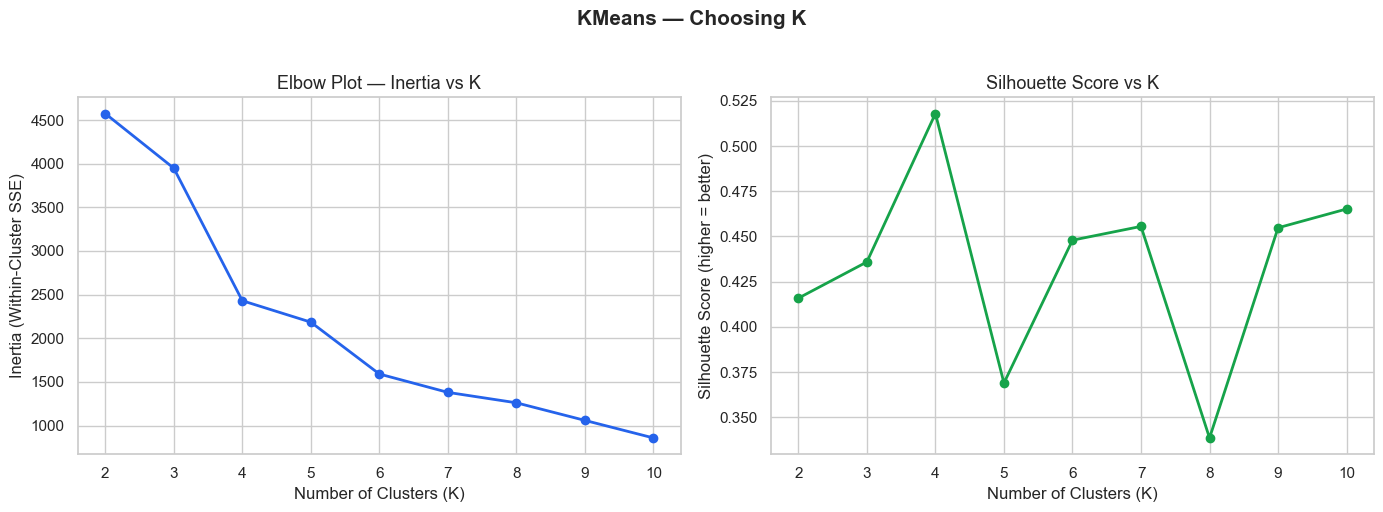

,k,inertia,silhouette
0,2,4574.4707,0.4159
1,3,3948.5866,0.4359
2,4,2429.8926,0.5180
3,5,2184.2638,0.3689
4,6,1589.9975,0.4480
5,7,1379.6645,0.4556
6,8,1260.1672,0.3385
7,9,1058.5424,0.4548
8,10,857.4388,0.4652


In [57]:
# ── Configuration ─────────────────────────────────────────────────
K_RANGE = range(2, 11)
KMEANS_SEED = 42
ELBOW_FIG_PATH = REPORT_FIG_DIR / 'kmeans_elbow.png'

# ── Compute inertia and silhouette across K ───────────────────────
elbow_rows = []

for k in K_RANGE:
    km = KMeans(n_clusters=k, random_state=KMEANS_SEED, n_init='auto')
    labels = km.fit_predict(feature_matrix_selected)
    sil = silhouette_score(feature_matrix_selected, labels)
    elbow_rows.append({
        'k': k,
        'inertia': km.inertia_,
        'silhouette': sil,
    })

elbow_df = pd.DataFrame(elbow_rows)

# ── Plot ──────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Inertia (elbow)
axes[0].plot(elbow_df['k'], elbow_df['inertia'], marker='o', color='#2563eb', linewidth=2)
axes[0].set_title('Elbow Plot — Inertia vs K', fontsize=13)
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Inertia (Within-Cluster SSE)')
axes[0].set_xticks(list(K_RANGE))

# Silhouette
axes[1].plot(elbow_df['k'], elbow_df['silhouette'], marker='o', color='#16a34a', linewidth=2)
axes[1].set_title('Silhouette Score vs K', fontsize=13)
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score (higher = better)')
axes[1].set_xticks(list(K_RANGE))

plt.suptitle('KMeans — Choosing K', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(ELBOW_FIG_PATH, dpi=150, bbox_inches='tight')
plt.show()

display(elbow_df.round(4))

K                   : 4
Silhouette Score    : 0.5180  (higher = better, max 1.0)
Davies-Bouldin Index: 0.7765  (lower  = better)
Calinski-Harabasz   : 96.0334  (higher = better)

Cluster sizes:
0     38
1    138
2      2
3     18


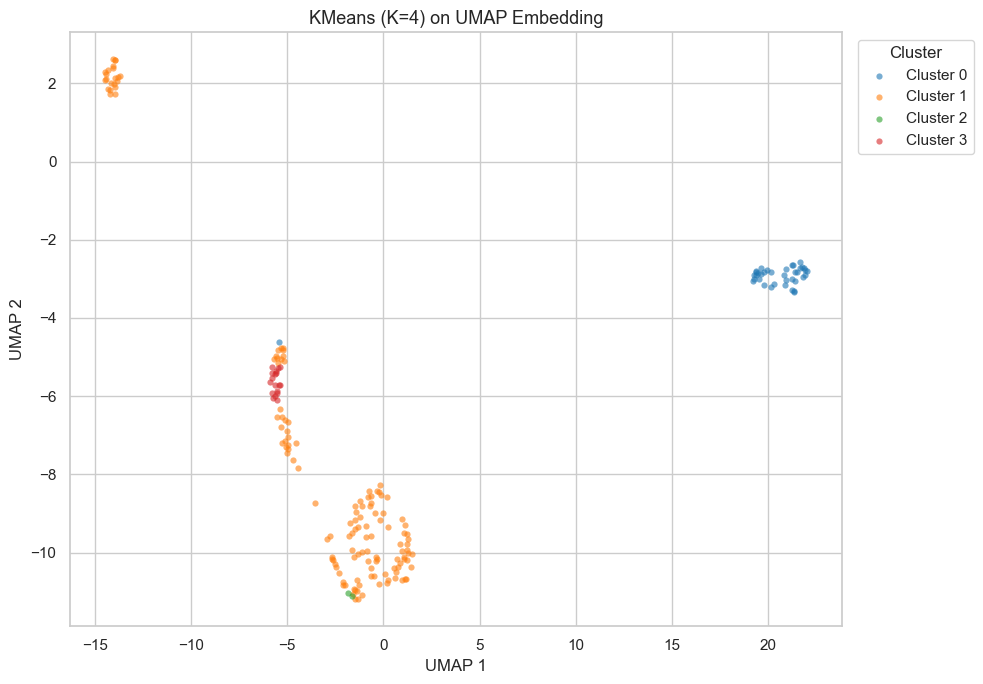


Labels saved to ..\outputs\eda\kmeans_labels_k4.csv


In [58]:
# ── Set K based on elbow plot observation ─────────────────────────
KMEANS_K = 4

KMEANS_FIG_PATH = REPORT_FIG_DIR / 'kmeans_umap.png'
KMEANS_OUTPUT_PATH = OUTPUT_DIR / f'kmeans_labels_k{KMEANS_K}.csv'

# ── Fit final KMeans ──────────────────────────────────────────────
km_final = KMeans(n_clusters=KMEANS_K, random_state=KMEANS_SEED, n_init='auto')
kmeans_labels = km_final.fit_predict(feature_matrix_selected)

adaptive_grid['kmeans_cluster'] = kmeans_labels

# ── Evaluation metrics ────────────────────────────────────────────
sil   = silhouette_score(feature_matrix_selected, kmeans_labels)
db    = davies_bouldin_score(feature_matrix_selected, kmeans_labels)
ch    = calinski_harabasz_score(feature_matrix_selected, kmeans_labels)
sizes = pd.Series(kmeans_labels).value_counts().sort_index()

print(f'K                   : {KMEANS_K}')
print(f'Silhouette Score    : {sil:.4f}  (higher = better, max 1.0)')
print(f'Davies-Bouldin Index: {db:.4f}  (lower  = better)')
print(f'Calinski-Harabasz   : {ch:.4f}  (higher = better)')
print(f'\nCluster sizes:\n{sizes.to_string()}')

# ── UMAP scatter coloured by KMeans label ─────────────────────────
umap_coords = pd.DataFrame(umap_coords, columns=['UMAP1', 'UMAP2'])
umap_coords['cluster'] = kmeans_labels.astype(str)

fig, ax = plt.subplots(figsize=(10, 7))
palette = sns.color_palette('tab10', n_colors=KMEANS_K)

for i, grp in umap_coords.groupby('cluster'):
    ax.scatter(grp['UMAP1'], grp['UMAP2'], label=f'Cluster {i}',
               color=palette[int(i)], alpha=0.6, s=20, linewidths=0)

ax.set_title(f'KMeans (K={KMEANS_K}) on UMAP Embedding', fontsize=13)
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.legend(title='Cluster', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.savefig(KMEANS_FIG_PATH, dpi=150, bbox_inches='tight')
plt.show()

# ── Save labels ───────────────────────────────────────────────────
adaptive_grid[['adaptive_cell_id', 'centroid_lat', 'centroid_lon', 'kmeans_cluster']].to_csv(
    KMEANS_OUTPUT_PATH, index=False
)
print(f'\nLabels saved to {KMEANS_OUTPUT_PATH}')

## Method 2: HDBSCAN

In [60]:
# ── Configuration ─────────────────────────────────────────────────
HDBSCAN_MIN_CLUSTER_SIZE = 10
HDBSCAN_MIN_SAMPLES      = 3
HDBSCAN_METRIC           = 'euclidean'

# ── Fit ───────────────────────────────────────────────────────────
hdb = hdbscan.HDBSCAN(
    min_cluster_size = HDBSCAN_MIN_CLUSTER_SIZE,
    min_samples      = HDBSCAN_MIN_SAMPLES,
    metric           = HDBSCAN_METRIC,
    prediction_data  = True,
)
hdbscan_labels = hdb.fit_predict(feature_matrix_selected)

adaptive_grid['hdbscan_cluster'] = hdbscan_labels

# ── Summary ───────────────────────────────────────────────────────
n_clusters   = len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)
n_noise      = int((hdbscan_labels == -1).sum())
noise_ratio  = n_noise / len(hdbscan_labels)

print(f'Clusters found  : {n_clusters}')
print(f'Noise points    : {n_noise} ({noise_ratio:.1%} of total)')
print(f'\nCluster sizes (excluding noise):')
print(pd.Series(hdbscan_labels[hdbscan_labels != -1]).value_counts().sort_index().to_string())

Clusters found  : 4
Noise points    : 18 (9.2% of total)

Cluster sizes (excluding noise):
0     20
1     36
2     21
3    101


Silhouette Score     : 0.4968  (higher = better)
Davies-Bouldin Index : 0.7597  (lower  = better)
Calinski-Harabasz    : 174.2587  (higher = better)
Noise Ratio          : 0.0918  (lower = better)


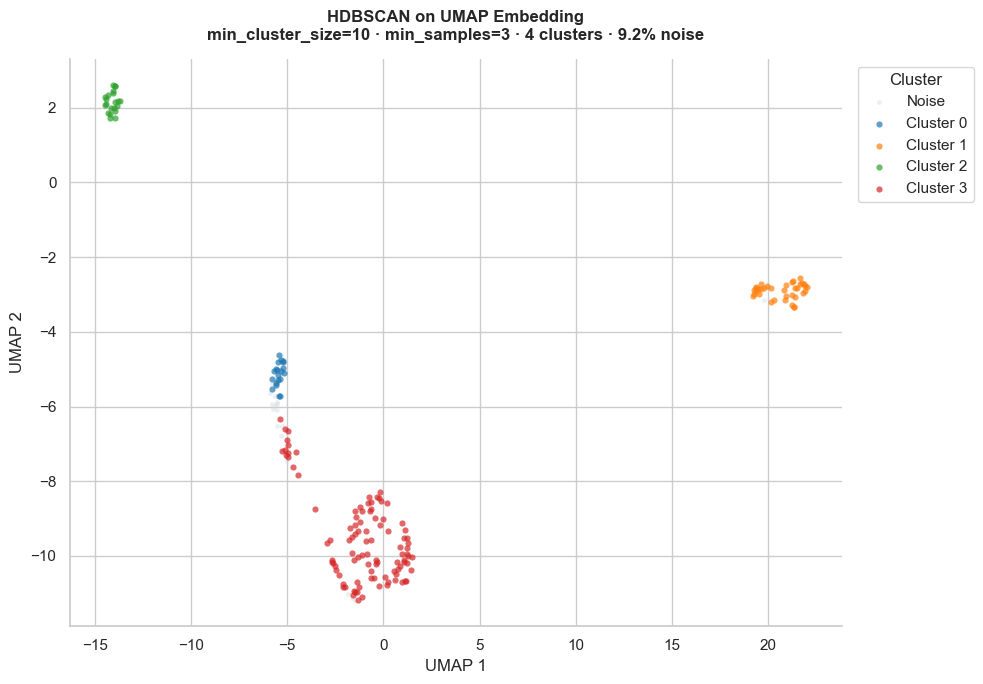


Labels saved to ..\outputs\eda\hdbscan_labels.csv


In [61]:
HDBSCAN_FIG_PATH = REPORT_FIG_DIR / 'hdbscan_umap.png'
HDBSCAN_OUTPUT_PATH = OUTPUT_DIR / 'hdbscan_labels.csv'

# ── Metrics (excluding noise points) ─────────────────────────────
mask = hdbscan_labels != -1

if mask.sum() > 0 and n_clusters > 1:
    sil = silhouette_score(feature_matrix_selected[mask], hdbscan_labels[mask])
    db  = davies_bouldin_score(feature_matrix_selected[mask], hdbscan_labels[mask])
    ch  = calinski_harabasz_score(feature_matrix_selected[mask], hdbscan_labels[mask])
else:
    sil = db = ch = float('nan')

print(f'Silhouette Score     : {sil:.4f}  (higher = better)')
print(f'Davies-Bouldin Index : {db:.4f}  (lower  = better)')
print(f'Calinski-Harabasz    : {ch:.4f}  (higher = better)')
print(f'Noise Ratio          : {noise_ratio:.4f}  (lower = better)')

# ── UMAP scatter coloured by HDBSCAN label ────────────────────────
plot_df = pd.DataFrame(umap_coords, columns=['UMAP1', 'UMAP2'])
plot_df['cluster'] = hdbscan_labels.astype(str)

fig, ax = plt.subplots(figsize=(10, 7))

# Plot noise points first in grey
noise_df = plot_df[plot_df['cluster'] == '-1']
ax.scatter(noise_df['UMAP1'], noise_df['UMAP2'],
           color='#d1d5db', s=12, alpha=0.4, label='Noise', linewidths=0)

# Plot clusters
cluster_ids = sorted([c for c in plot_df['cluster'].unique() if c != '-1'], key=int)
palette = sns.color_palette('tab10', n_colors=len(cluster_ids))

for i, cid in enumerate(cluster_ids):
    grp = plot_df[plot_df['cluster'] == cid]
    ax.scatter(grp['UMAP1'], grp['UMAP2'],
               color=palette[i], s=20, alpha=0.7,
               label=f'Cluster {cid}', linewidths=0)

ax.set_title(
    f'HDBSCAN on UMAP Embedding\n'
    f'min_cluster_size={HDBSCAN_MIN_CLUSTER_SIZE} · '
    f'min_samples={HDBSCAN_MIN_SAMPLES} · '
    f'{n_clusters} clusters · {noise_ratio:.1%} noise',
    fontsize=12, fontweight='bold', pad=14,
)
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.legend(title='Cluster', bbox_to_anchor=(1.01, 1), loc='upper left')
sns.despine()
plt.tight_layout()
plt.savefig(HDBSCAN_FIG_PATH, dpi=150, bbox_inches='tight')
plt.show()

# ── Save labels ───────────────────────────────────────────────────
adaptive_grid[['adaptive_cell_id', 'centroid_lat', 'centroid_lon', 'hdbscan_cluster']].to_csv(
    HDBSCAN_OUTPUT_PATH, index=False
)
print(f'\nLabels saved to {HDBSCAN_OUTPUT_PATH}')

## Method 3: DBSCAN

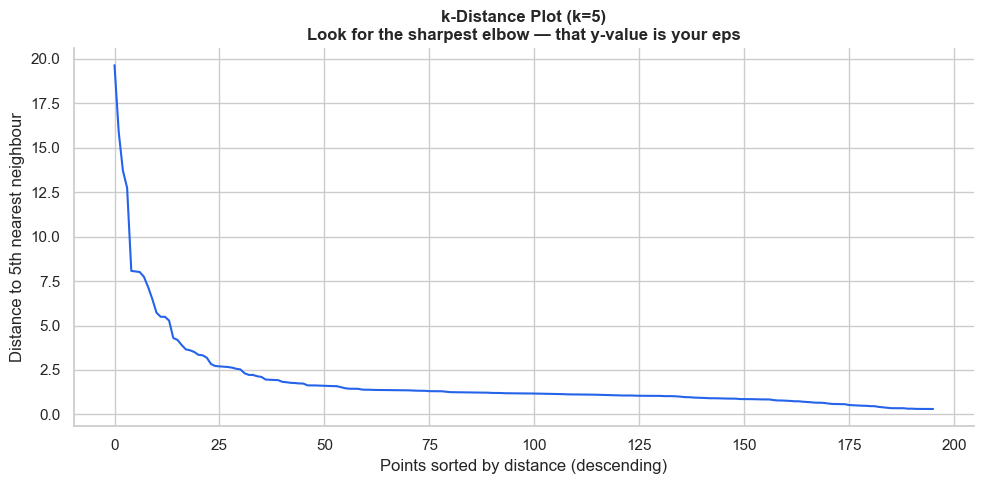

In [63]:
# ── Configuration ─────────────────────────────────────────────────
DBSCAN_K_NEIGHBORS = 5

# ── Fit nearest neighbours and plot sorted distances ──────────────
nbrs = NearestNeighbors(n_neighbors=DBSCAN_K_NEIGHBORS).fit(feature_matrix_selected)
distances, _ = nbrs.kneighbors(feature_matrix_selected)
k_distances = np.sort(distances[:, -1])[::-1]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(k_distances, color='#2563eb', linewidth=1.5)
ax.set_title(
    f'k-Distance Plot (k={DBSCAN_K_NEIGHBORS})\n'
    f'Look for the sharpest elbow — that y-value is your eps',
    fontsize=12, fontweight='bold'
)
ax.set_xlabel('Points sorted by distance (descending)')
ax.set_ylabel(f'Distance to {DBSCAN_K_NEIGHBORS}th nearest neighbour')
sns.despine()
plt.tight_layout()
plt.savefig(REPORT_FIG_DIR / 'dbscan_kdistance.png', dpi=150, bbox_inches='tight')
plt.show()

In [64]:
# ── Configuration — set eps from k-distance plot above ────────────
DBSCAN_EPS         = 2.5
DBSCAN_MIN_SAMPLES = 5

# ── Fit ───────────────────────────────────────────────────────────
dbs = DBSCAN(eps=DBSCAN_EPS, min_samples=DBSCAN_MIN_SAMPLES)
dbscan_labels = dbs.fit_predict(feature_matrix_selected)

adaptive_grid['dbscan_cluster'] = dbscan_labels

n_clusters  = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise     = int((dbscan_labels == -1).sum())
noise_ratio = n_noise / len(dbscan_labels)

print(f'Clusters found : {n_clusters}')
print(f'Noise points   : {n_noise} ({noise_ratio:.1%} of total)')
print(f'\nCluster sizes (excluding noise):')
print(pd.Series(dbscan_labels[dbscan_labels != -1]).value_counts().sort_index().to_string())

Clusters found : 4
Noise points   : 26 (13.3% of total)

Cluster sizes (excluding noise):
0    102
1     36
2     21
3     11


Silhouette Score     : 0.5298  (higher = better)
Davies-Bouldin Index : 0.6241  (lower  = better)
Calinski-Harabasz    : 244.0771  (higher = better)
Noise Ratio          : 0.1327  (lower = better)


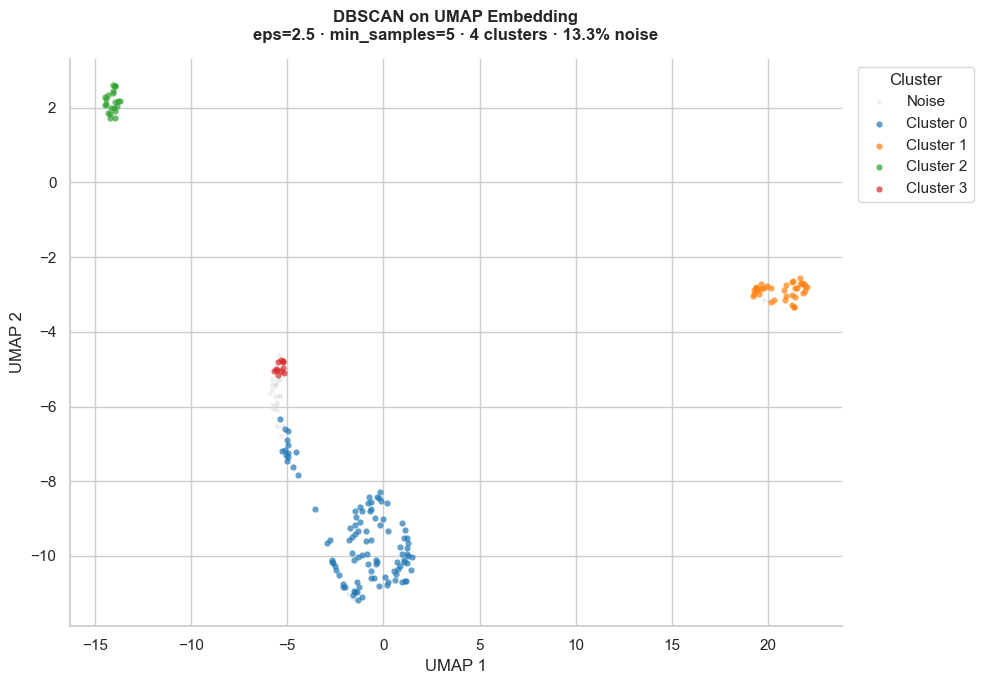


Labels saved to ..\outputs\eda\dbscan_labels.csv


In [65]:
DBSCAN_FIG_PATH    = REPORT_FIG_DIR / 'dbscan_umap.png'
DBSCAN_OUTPUT_PATH = OUTPUT_DIR / 'dbscan_labels.csv'

# ── Metrics (excluding noise) ─────────────────────────────────────
mask = dbscan_labels != -1

if mask.sum() > 0 and n_clusters > 1:
    sil = silhouette_score(feature_matrix_selected[mask], dbscan_labels[mask])
    db  = davies_bouldin_score(feature_matrix_selected[mask], dbscan_labels[mask])
    ch  = calinski_harabasz_score(feature_matrix_selected[mask], dbscan_labels[mask])
else:
    sil = db = ch = float('nan')

print(f'Silhouette Score     : {sil:.4f}  (higher = better)')
print(f'Davies-Bouldin Index : {db:.4f}  (lower  = better)')
print(f'Calinski-Harabasz    : {ch:.4f}  (higher = better)')
print(f'Noise Ratio          : {noise_ratio:.4f}  (lower = better)')

# ── UMAP scatter ──────────────────────────────────────────────────
plot_df = pd.DataFrame(umap_coords, columns=['UMAP1', 'UMAP2'])
plot_df['cluster'] = dbscan_labels.astype(str)

fig, ax = plt.subplots(figsize=(10, 7))

noise_df = plot_df[plot_df['cluster'] == '-1']
ax.scatter(noise_df['UMAP1'], noise_df['UMAP2'],
           color='#d1d5db', s=12, alpha=0.4, label='Noise', linewidths=0)

cluster_ids = sorted([c for c in plot_df['cluster'].unique() if c != '-1'], key=int)
palette = sns.color_palette('tab10', n_colors=max(len(cluster_ids), 1))

for i, cid in enumerate(cluster_ids):
    grp = plot_df[plot_df['cluster'] == cid]
    ax.scatter(grp['UMAP1'], grp['UMAP2'],
               color=palette[i], s=20, alpha=0.7,
               label=f'Cluster {cid}', linewidths=0)

ax.set_title(
    f'DBSCAN on UMAP Embedding\n'
    f'eps={DBSCAN_EPS} · min_samples={DBSCAN_MIN_SAMPLES} · '
    f'{n_clusters} clusters · {noise_ratio:.1%} noise',
    fontsize=12, fontweight='bold', pad=14,
)
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.legend(title='Cluster', bbox_to_anchor=(1.01, 1), loc='upper left')
sns.despine()
plt.tight_layout()
plt.savefig(DBSCAN_FIG_PATH, dpi=150, bbox_inches='tight')
plt.show()

# ── Save labels ───────────────────────────────────────────────────
adaptive_grid[['adaptive_cell_id', 'centroid_lat', 'centroid_lon', 'dbscan_cluster']].to_csv(
    DBSCAN_OUTPUT_PATH, index=False
)
print(f'\nLabels saved to {DBSCAN_OUTPUT_PATH}')

## Clustering Summary  

### Done thus far  

- Built an adaptive spatial grid over Toronto where each cell contains exactly 3 rental listings, sized by local density (small cells downtown, larger ones in the suburbs)
- Engineered features per cell covering rent levels, crime rates, restaurant density, and transit access, plus ratio and tier features to capture neighbourhood profile tradeoffs
- Used cluster-stability permutation importance to select only the features that meaningfully contribute to cluster structure (top 90% of cumulative importance)
- Ran PCA and UMAP to visualize the feature space in 2D before clustering
- Tested three clustering methods: KMeans, HDBSCAN, and DBSCAN

### Results of the clustering methods

| Method | Clusters | Noise Ratio | Notes |
|--------|----------|-------------|-------|
| KMeans (k=4) | 4 | 0% | forced k, no noise concept |
| HDBSCAN | 4 | 9.2% | found k=4 independently |
| DBSCAN (eps=2.5) | 4 | 13.3% | competitive but noisier than HDBSCAN |

### Why HDBSCAN wins

- it independently discovered 4 clusters without being told to, matching KMeans exactly. this is strong evidence the structure is real and not an artifact of the algorithm
- it handles variable density across the city naturally, which matters a lot here since downtown Toronto is far denser than the suburbs
- its noise ratio of 9.2% is lower than DBSCAN's 13.3%, and DBSCAN required manual eps tuning via a k-distance plot to get there. HDBSCAN needed far less calibration
- DBSCAN's single global eps parameter is a poor fit for spatially uneven data like this. no single value can work well everywhere across a whole city
- KMeans has no noise concept at all, forcing every cell into a cluster even if it genuinely doesn't belong to one

HDBSCAN is carried forward as the primary clustering result.

### HDBSCAN Cluster Interpretation (Post-Summary)

This section interprets HDBSCAN clusters from the feature-importance output and validates the main themes spatially:

- **Cluster 0** is transit-driven.
- **Cluster 1** is safety-driven.
- **Cluster 2** is restaurant-driven.

We first compute feature importance per cluster (vs global profile), then produce targeted spatial overlays for each interpretation.


In [ ]:
# ── HDBSCAN post-summary interpretation and targeted diagnostics ───────────
HDBSCAN_IMPORTANCE_FIG_PATH = REPORT_FIG_DIR / 'hdbscan_cluster_feature_importance.png'
HDBSCAN_C0_TRANSIT_FIG_PATH = REPORT_FIG_DIR / 'hdbscan_cluster0_transit_stations.png'
HDBSCAN_C1_CRIME_FIG_PATH = REPORT_FIG_DIR / 'hdbscan_cluster1_crime_heatmap.png'
HDBSCAN_C2_RESTAURANT_FIG_PATH = REPORT_FIG_DIR / 'hdbscan_cluster2_restaurant_price_heatmap.png'

# Contrast thresholds for interpretation maps
CRIME_RATE_LOW_Q = 0.55
CRIME_RATE_HIGH_Q = 0.95
RESTAURANT_PRICE_LOW_Q = 0.60
RESTAURANT_PRICE_HIGH_Q = 0.95

# Build cluster profile matrix (exclude noise)
hdb_mask = adaptive_grid['hdbscan_cluster'] != -1
profile_df = feature_matrix_selected.loc[hdb_mask].copy()
profile_df['cluster'] = adaptive_grid.loc[hdb_mask, 'hdbscan_cluster'].astype(int).values

if profile_df['cluster'].nunique() == 0:
    print('No non-noise HDBSCAN clusters were found; interpretation skipped.')
else:
    feature_cols = [c for c in profile_df.columns if c != 'cluster']

    cluster_means = profile_df.groupby('cluster', sort=True)[feature_cols].mean()
    global_mean = profile_df[feature_cols].mean()
    global_std = profile_df[feature_cols].std(ddof=0).replace(0, np.nan)

    signed_importance = (cluster_means - global_mean).div(global_std, axis=1).fillna(0.0)
    abs_importance = signed_importance.abs()

    # Plot feature importance heatmaps
    feature_order = abs_importance.mean(axis=0).sort_values(ascending=False).index
    abs_plot = abs_importance[feature_order]
    signed_plot = signed_importance[feature_order]

    fig_h = max(5, 1.0 * abs_plot.shape[0] + 2)
    fig_w = max(12, 0.35 * abs_plot.shape[1] + 8)

    fig, axes = plt.subplots(1, 2, figsize=(fig_w, fig_h), gridspec_kw={'width_ratios': [1, 1]})

    sns.heatmap(
        abs_plot,
        ax=axes[0],
        cmap='YlOrRd',
        linewidths=0.4,
        linecolor='white',
        cbar_kws={'label': '|z-score| importance'},
    )
    axes[0].set_title('HDBSCAN Cluster Feature Importance (Absolute)', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Feature')
    axes[0].set_ylabel('Cluster')
    axes[0].tick_params(axis='x', rotation=70)

    sns.heatmap(
        signed_plot,
        ax=axes[1],
        cmap='coolwarm',
        center=0,
        linewidths=0.4,
        linecolor='white',
        cbar_kws={'label': 'Signed z-score (vs global mean)'},
    )
    axes[1].set_title('Direction of Difference (Higher vs Lower)', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Feature')
    axes[1].set_ylabel('Cluster')
    axes[1].tick_params(axis='x', rotation=70)

    plt.suptitle('HDBSCAN Cluster Profiles Relative to Overall Market', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(HDBSCAN_IMPORTANCE_FIG_PATH, dpi=150, bbox_inches='tight')
    plt.show()

    # Printed interpretation from output
    cluster_sizes = profile_df['cluster'].value_counts().sort_index()
    TOP_K = min(5, len(feature_cols))

    print('
Cluster differentiation summary (top features by |z-score|):')
    for cid in sorted(signed_importance.index):
        top_feats = abs_importance.loc[cid].sort_values(ascending=False).head(TOP_K).index
        parts = []
        for feat in top_feats:
            z = signed_importance.loc[cid, feat]
            direction = 'higher' if z > 0 else 'lower'
            parts.append(f"{feat} ({direction}, z={z:+.2f})")

        print(f"- Cluster {cid} (n={cluster_sizes.loc[cid]}): " + '; '.join(parts))

    print('
Interpretation based on feature-importance output:')
    print('- Cluster 0 is interpreted as transit-related (strong transit feature deviations).')
    print('- Cluster 1 is interpreted as safety-related (strong safety/crime feature deviations).')
    print('- Cluster 2 is interpreted as restaurant-related (strong food-access/restaurant feature deviations).')

    # ---------------------------------------------------------------------
    # Targeted map 1: Cluster 0 + subway stations (transit)
    # ---------------------------------------------------------------------
    if 0 in adaptive_grid['hdbscan_cluster'].values:
        fig, ax = plt.subplots(figsize=(10, 8))

        ax.scatter(
            adaptive_grid['centroid_lon'],
            adaptive_grid['centroid_lat'],
            color='#d1d5db',
            s=10,
            alpha=0.25,
            linewidths=0,
            label='Other cells'
        )

        c0 = adaptive_grid['hdbscan_cluster'] == 0
        ax.scatter(
            adaptive_grid.loc[c0, 'centroid_lon'],
            adaptive_grid.loc[c0, 'centroid_lat'],
            color='#2563eb',
            s=24,
            alpha=0.8,
            linewidths=0,
            label='HDBSCAN Cluster 0 (Transit)'
        )

        station_lat_col = 'latitude' if 'latitude' in subway.columns else 'Latitude'
        station_lon_col = 'longitude' if 'longitude' in subway.columns else 'Longitude'
        ax.scatter(
            subway[station_lon_col],
            subway[station_lat_col],
            color='#ef4444',
            s=45,
            marker='^',
            edgecolors='white',
            linewidths=0.6,
            alpha=0.95,
            label='Subway stations'
        )

        ax.set_title('Transit Interpretation: HDBSCAN Cluster 0 with Subway Stations', fontsize=13, fontweight='bold')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.legend(loc='upper left')
        ax.set_aspect('equal')
        sns.despine()
        plt.tight_layout()
        plt.savefig(HDBSCAN_C0_TRANSIT_FIG_PATH, dpi=150, bbox_inches='tight')
        plt.show()

    # ---------------------------------------------------------------------
    # Targeted map 2: Thresholded crime-rate heatmap + Cluster 1 dots
    # ---------------------------------------------------------------------
    if 1 in adaptive_grid['hdbscan_cluster'].values:
        fig, ax = plt.subplots(figsize=(10, 8))

        if 'crime_per_km2' in adaptive_grid.columns:
            crime_rate = adaptive_grid['crime_per_km2'].astype(float)
        else:
            crime_rate = adaptive_grid['crime_count_in_circle'] / (adaptive_grid['cell_area_km2'] + 1e-6)

        crime_rate = crime_rate.replace([np.inf, -np.inf], np.nan)
        valid_crime = crime_rate.notna()

        if valid_crime.sum() > 0:
            crime_low = float(crime_rate[valid_crime].quantile(CRIME_RATE_LOW_Q))
            crime_high = float(crime_rate[valid_crime].quantile(CRIME_RATE_HIGH_Q))
            crime_mask = valid_crime & (crime_rate >= crime_low)
            crime_values = crime_rate.clip(lower=crime_low, upper=crime_high)

            crime_hm = ax.hexbin(
                adaptive_grid.loc[crime_mask, 'centroid_lon'],
                adaptive_grid.loc[crime_mask, 'centroid_lat'],
                C=crime_values.loc[crime_mask],
                reduce_C_function=np.mean,
                gridsize=70,
                cmap='Reds',
                mincnt=1,
                alpha=0.8,
                linewidths=0,
            )
            cb = plt.colorbar(crime_hm, ax=ax)
            cb.set_label(f'Crime rate (per km^2), clipped to Q{int(CRIME_RATE_LOW_Q*100)}-Q{int(CRIME_RATE_HIGH_Q*100)}')
            print(f'Crime-rate thresholds: low={crime_low:.2f}, high={crime_high:.2f}')
        else:
            print('Crime-rate heatmap skipped: no valid values.')

        c1 = adaptive_grid['hdbscan_cluster'] == 1
        ax.scatter(
            adaptive_grid.loc[c1, 'centroid_lon'],
            adaptive_grid.loc[c1, 'centroid_lat'],
            color='#111827',
            s=30,
            alpha=0.92,
            linewidths=0.2,
            edgecolors='white',
            label='HDBSCAN Cluster 1 (Safety)'
        )

        ax.set_title('Safety Interpretation: Thresholded Crime-Rate Heatmap with HDBSCAN Cluster 1', fontsize=13, fontweight='bold')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.legend(loc='upper left')
        ax.set_aspect('equal')
        sns.despine()
        plt.tight_layout()
        plt.savefig(HDBSCAN_C1_CRIME_FIG_PATH, dpi=150, bbox_inches='tight')
        plt.show()

    # ---------------------------------------------------------------------
    # Targeted map 3: Thresholded avg-price heatmap + Cluster 2 dots
    # ---------------------------------------------------------------------
    if 2 in adaptive_grid['hdbscan_cluster'].values:
        fig, ax = plt.subplots(figsize=(10, 8))

        rest_price = rest_venue['restaurant_price_mid'].astype(float).replace([np.inf, -np.inf], np.nan)
        valid_rest = rest_price.notna()

        if valid_rest.sum() > 0:
            price_low = float(rest_price[valid_rest].quantile(RESTAURANT_PRICE_LOW_Q))
            price_high = float(rest_price[valid_rest].quantile(RESTAURANT_PRICE_HIGH_Q))
            rest_mask = valid_rest & (rest_price >= price_low)
            rest_price_clipped = rest_price.clip(lower=price_low, upper=price_high)

            rest_price_hm = ax.hexbin(
                rest_venue.loc[rest_mask, 'Restaurant Longitude'],
                rest_venue.loc[rest_mask, 'Restaurant Latitude'],
                C=rest_price_clipped.loc[rest_mask],
                reduce_C_function=np.mean,
                gridsize=80,
                cmap='viridis',
                mincnt=1,
                alpha=0.85,
                linewidths=0,
            )
            cb = plt.colorbar(rest_price_hm, ax=ax)
            cb.set_label(f'Avg restaurant price midpoint, clipped to Q{int(RESTAURANT_PRICE_LOW_Q*100)}-Q{int(RESTAURANT_PRICE_HIGH_Q*100)}')
            print(f'Restaurant-price thresholds: low={price_low:.2f}, high={price_high:.2f}')
        else:
            print('Restaurant-price heatmap skipped: no valid values.')

        c2 = adaptive_grid['hdbscan_cluster'] == 2
        ax.scatter(
            adaptive_grid.loc[c2, 'centroid_lon'],
            adaptive_grid.loc[c2, 'centroid_lat'],
            color='#f97316',
            s=30,
            alpha=0.9,
            linewidths=0.2,
            edgecolors='white',
            label='HDBSCAN Cluster 2 (Restaurants)'
        )

        ax.set_title('Restaurant Interpretation: Thresholded Avg-Price Heatmap with HDBSCAN Cluster 2', fontsize=13, fontweight='bold')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.legend(loc='upper left')
        ax.set_aspect('equal')
        sns.despine()
        plt.tight_layout()
        plt.savefig(HDBSCAN_C2_RESTAURANT_FIG_PATH, dpi=150, bbox_inches='tight')
        plt.show()

    print(f'
Saved figures:')
    print(f'- {HDBSCAN_IMPORTANCE_FIG_PATH}')
    print(f'- {HDBSCAN_C0_TRANSIT_FIG_PATH}')
    print(f'- {HDBSCAN_C1_CRIME_FIG_PATH}')
    print(f'- {HDBSCAN_C2_RESTAURANT_FIG_PATH}')

